# IndiaSim ABM - Rotavirus

### For age categories 0-4 (rotavirus is most prominant in this demographic, most data availible is for this age group)

In [1]:
#import Pkg # for installing packages/package manager
## get packages that are necessary or install them if they don't exist in the current environment
#Pkg.add(["Agents", "Random", "DataFrames", "Distributions", "DrWatson", "gamma_latest_3_22_current_Plots","StatsBase",
# "CSV", "DataStructures","Pickle"])

In [2]:
using Agents, Random, DataFrames, CSV, DataStructures
using Distributions
using DrWatson: @dict
using Plots
using Pickle

In [3]:
#Below function is used to model the transmission rate that decreases by an exponential scale nearing the end of the
    #infection period
function exponential_decay(first,last,steps)
    multiplicative_factor=(last/first)^(1/steps)    
    return multiplicative_factor.^(1:steps).*first
end


exponential_decay (generic function with 1 method)

In [4]:
#Sample individual reproductive number using Fi distribution
function R_distribution(age,mean_R0,Fi_vals,state,district,mean_Fi)
    #println(Fi_vals[age+1])
    Fi_val=Fi_vals[age+1]
    if Fi_val<0
        Fi_val=0
    end
    r_val=rand(Rayleigh(Fi_val/(mean_Fi))*mean_R0)
    #println("r_val ",r_val)
    #println("Fi:",Fi_val," mean Fi:",mean_Fi," ReprodNum:",r_val)
    return r_val
end

R_distribution (generic function with 1 method)

In [5]:
days_hosp_df = DataFrame(CSV.File("days_hospitalized_distribution.csv"))

#We use COVID distribution of hospitalization until death shape, as it likely is similar to rotavirus hospitalization shape,
    #going by the listed ranges (for rota: median 3, with wide range, 1–41 days). Also, data about the distribution 
    #shape is very limited for diseases.

#COVID hospitalization data shape till death (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7589278/), 
    #scaled to Rotavirus data (median=3) - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3461720

days_hosp_dist=Float64[]

for row in Tables.namedtupleiterator(days_hosp_df)
    for times in 1:trunc(Int,round(row[2]*10000))
        push!(days_hosp_dist,row[1])
    end
end

average_hospitalized=mean(days_hosp_dist)

for i in 1:length(days_hosp_dist)
    days_hosp_dist[i]*=3/average_hospitalized
end

days_hosp_dist_round=Int64[]

for i in 1:length(days_hosp_dist)
    push!(days_hosp_dist_round,trunc(Int,round(days_hosp_dist[i]+1)))
end

alpha,theta=Distributions.params(fit_mle(Gamma, days_hosp_dist_round))

(2.432065064388565, 1.6619414174364122)

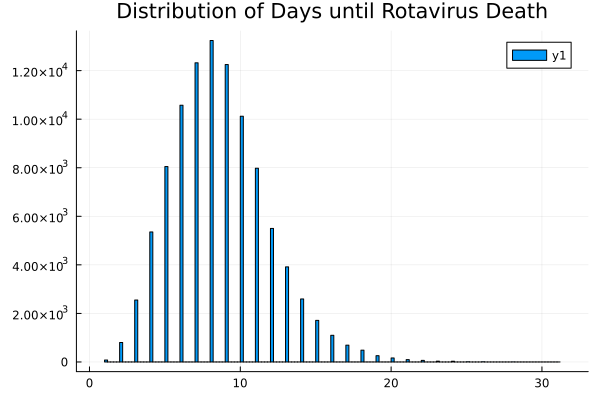

In [6]:
days_hospitalized = []

for i in 1:100000
    #incubation period + aribtrary 0-5 day delay before hospitalization
    push!(days_hospitalized,rand(1:3)+ rand(0:5) +trunc(Int,round(rand(Gamma(alpha,theta)))))
end

histogram(days_hospitalized, title="Distribution of Days until Rotavirus Death")

In [7]:
days_infectious = DataFrame(CSV.File("rotavirus days infectious.csv"))

#We use gamma COVID distribution of infectious days (https://bmjopen.bmj.com/content/10/8/e039856)

    #scaled to Rotavirus data (median=12) - various online sources

days_infectious_dist=Float64[]

for row in Tables.namedtupleiterator(days_hosp_df)
    for times in 1:trunc(Int,round(row[2]*10000))
        push!(days_infectious_dist,row[1])
    end
end

average_infectious=mean(days_infectious_dist)

for i in 1:length(days_infectious_dist)
    days_infectious_dist[i]*=12/average_infectious
end

days_infectious_dist_round=Int64[]

for i in 1:length(days_infectious_dist)
    push!(days_infectious_dist_round,trunc(Int,round(days_infectious_dist[i]+1)))
end

alpha_inf=Distributions.params(fit_mle(Rayleigh, days_infectious_dist_round))

(12.422371819184255,)

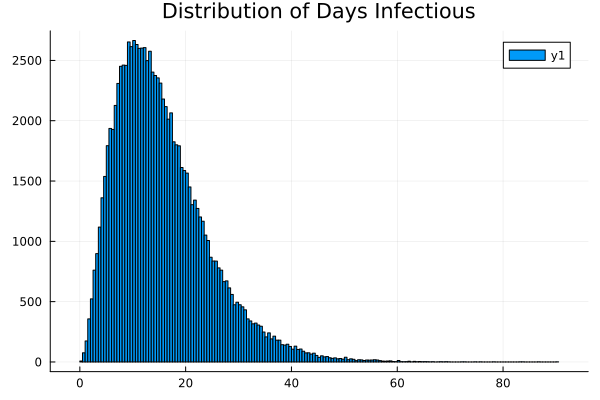

In [8]:
days_infectious = Int64[]

for i in 1:100000
    #incubation period + aribtrary 0-5 day delay before hospitalization
    push!(days_infectious,trunc(Int,round(rand(Rayleigh(alpha_inf[1])))))
end

days_infectious=[i==0 ? 1 : i for i in days_infectious]
infect_alpha,infect_beta=Distributions.params(fit_mle(Gamma, days_infectious))

days_infectious=[]
for i in 1:100000
    #incubation period + aribtrary 0-5 day delay before hospitalization
    push!(days_infectious,rand(Gamma(infect_alpha,infect_beta)))
end


histogram(days_infectious, title="Distribution of Days Infectious")

In [9]:
#Next function is the distributions of vaccine efficacy for agent sampling

vaccine_efficacy_low_bound=0.5 #https://academic.oup.com/cid/article/65/5/840/3746914
vaccine_efficacy_up_bound=0.64 #https://academic.oup.com/cid/article/65/5/840/3746914

relative_effects_wealth = [2.33,1.99,1.56,1.17,0.69]
relative_effects_wealth=[i/mean(relative_effects_wealth) for i in relative_effects_wealth]


relative_abx_use_wealth=[46.2,49.2,51.7,56.7,41.8]
relative_abx_use_wealth=[i/mean(relative_abx_use_wealth) for i in relative_abx_use_wealth]

function vaccine_efficacy_dist(lower=vaccine_efficacy_low_bound,upper=vaccine_efficacy_up_bound)
    return rand(Uniform(lower,upper))
end

antibiotics_vaccination_df = DataFrame(CSV.File("antibiotics_childhood_vaccination.csv"))
under_two_vaccination_abx=antibiotics_vaccination_df[isequal.(antibiotics_vaccination_df[!,"Vaccine"],"Rotavirus") .& isequal.(antibiotics_vaccination_df[!,"Age group (months)"],"0-23").& isequal.(antibiotics_vaccination_df[!,"Outcome against which Protection is Evaluated"],"Diarrhea"),"Estimated VE"][[1,3]] # new data frame
two_to_five_vaccination_abx=antibiotics_vaccination_df[isequal.(antibiotics_vaccination_df[!,"Vaccine"],"Rotavirus") .& isequal.(antibiotics_vaccination_df[!,"Age group (months)"],"24-59").& isequal.(antibiotics_vaccination_df[!,"Outcome against which Protection is Evaluated"],"Diarrhea"),"Estimated VE"][[1,3]] # new data frame
five_plus_vaccination_abx=antibiotics_vaccination_df[isequal.(antibiotics_vaccination_df[!,"Vaccine"],"Rotavirus") .& isequal.(antibiotics_vaccination_df[!,"Age group (months)"],"24-59").& isequal.(antibiotics_vaccination_df[!,"Outcome against which Protection is Evaluated"],"Diarrhea"),"Estimated VE"][[1,3]] # new data frame
five_plus_factor=(five_plus_vaccination_abx[2]-five_plus_vaccination_abx[1])/2
five_plus_vaccination_abx[1]-=five_plus_factor
five_plus_vaccination_abx[2]+=five_plus_factor

#This function uses agent age and reproductive number; it calculates tranmission rate by day for each day of infection.
    #It also determines whether the agent will die, and days of infection until death if so, and whether the agent
    #will take antibiotics, and the day if so.
function transmission_rate(age, wealth, vaccine_efficacy,state,district,R_distribution,days_incubate=rand(1:3),days_increase=rand(3:6),
    days_decrease_linear=rand(4:25), days_decrease_exponential=rand(3:4))   
    

    days_infected = rand(Gamma(infect_alpha,infect_beta))
    
    days_increase=trunc(Int,round(days_infected/3))
    days_decrease_linear=trunc(Int,round(days_infected/3))
    days_decrease_exponential=trunc(Int,round(days_infected/3))
    
    if days_increase+days_decrease_linear+days_decrease_linear<1
        days_increase=1
    end



    #Scaling the reproductive number based on differential # of contacts by age
    #scales mean R0 by total contacts given agent age using gamma distribution sampling
    reproductive_number=rand(Gamma(R_distribution[1],R_distribution[2]))/100000
    
    transmission_scale = Vector{Float64}(undef,days_incubate+days_increase+days_decrease_linear+days_decrease_exponential)
    
    trans_index=1
    
    for i in zeros(days_incubate)
        transmission_scale[trans_index]=i
        trans_index+=1
    end   
        
    if days_increase==1
        transmission_scale[trans_index]=1
        trans_index+=1

    elseif days_increase>1
        for i in LinRange(0,1,days_increase+1)[2:days_increase+1] #Need to add 1 to function because LinRange adds 0 as first value, then index 2: to remove 0
            transmission_scale[trans_index]=i
            trans_index+=1
        end
    end
    
    if days_decrease_linear==1
        transmission_scale[trans_index]=rand(Uniform(1/3,2/3))
        trans_index+=1
    elseif days_decrease_linear>1
        for i in LinRange(1,rand(Uniform(1/3,2/3)),days_decrease_linear+1)[2:days_decrease_linear+1] #Need to add 1 to function because LinRange adds 0 as first value, then index 2: to remove 0
            transmission_scale[trans_index]=i
            trans_index+=1
        end
    end

    for i in exponential_decay(transmission_scale[trans_index-1],rand(Uniform(1/100,1/5)),days_decrease_exponential)
        transmission_scale[trans_index]=i
        trans_index+=1
    end 
    
    transmission_scale=transmission_scale.*(reproductive_number/sum(transmission_scale[1:trans_index-1]))
     
    days_till_antibiotic=-1#default is no antibiotic seeking
    
    #agent will seek antibiotics 1-5 days after onset of symptoms
    
    
    #probability of antibiotics influenced by incidence of diarrhea, rate of abx use if diarrhea is present, and wealth quintile
    
    if age<2
        #probability to have diarrhea https://www.nejm.org/doi/full/10.1056/nejmoa1006261
        #probability to take antibiotics if diarrhea: Table S13 of https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-020-2238-4/MediaObjects/41586_2020_2238_MOESM1_ESM.pdf
        prob_abx=282/519*(441/250)*0.189*relative_abx_use_wealth[wealth]
    else
        prob_abx=282/519*(59/250)*0.189*relative_abx_use_wealth[wealth]
    end

    
    if vaccine_efficacy>0 #If vaccinated, transmission rate and death probability are reduced; below is also
                            #the probability they will seek antibiotics (based on age)
        transmission_scale.*0.75 #reduced transmission rate by arbitrary 25%
        
        if age<2
            if age<1 #if 0-1 yrs old
                #Accounting for the -0.066 in the CI of -0.066 to 0.19
                if vaccine_efficacy<prob_abx*(vaccine_efficacy_low_bound+
                        (vaccine_efficacy_up_bound-vaccine_efficacy_low_bound)*abs(under_two_vaccination_abx[1])/
                    (abs(under_two_vaccination_abx[1])+under_two_vaccination_abx[2]))
                    days_till_antibiotic=days_incubate + rand(1:5)

                elseif rand(Uniform(0,1))< prob_abx*rand(Uniform(under_two_vaccination_abx[1],under_two_vaccination_abx[2]))#Probability sourced from:https://www.nature.com/articles/s41586-020-2238-4 (Roughly symmetric CIs)
                    days_till_antibiotic=days_incubate + rand(1:5)
                end
            
                #if 2-5 years old
            
            elseif rand(Uniform(0,1))> rand(Uniform(two_to_five_vaccination_abx[1],two_to_five_vaccination_abx[2])) 
                    days_till_antibiotic=days_incubate + rand(1:5)
            end
        #if 5+ years old
        elseif vaccine_efficacy<vaccine_efficacy_low_bound+ #Accounting for negative lower bound here as well
                        (vaccine_efficacy_up_bound-vaccine_efficacy_low_bound)*abs(five_plus_vaccination_abx[1])/
                    (abs(five_plus_vaccination_abx[1])+five_plus_vaccination_abx[2])
            
        elseif rand(Uniform(0,1))> rand(Uniform(five_plus_vaccination_abx[1],five_plus_vaccination_abx[2]))#Probability sourced from:https://www.nature.com/articles/s41586-020-2238-4 (Roughly symmetric CIs)
                    days_till_antibiotic=days_incubate + rand(1:5)

        end
    
    else #if not vaccinated, seek antibiotics according to wealth quintile
        
        
        antibiotics_outcome = rand(Uniform(0,1))
        
        #Below if statement: scale overall probability to be administered antibiotics based on wealth quintile 
        if antibiotics_outcome < prob_abx
            
            days_till_antibiotic=days_incubate + rand(1:5)
        end

    end

        
            
    if age<2 #Probability clinic visit from https://www.nejm.org/doi/full/10.1056/nejmoa1006261
        #Death probability if clinic visit from: https://www.sciencedirect.com/science/article/pii/S0264410X14003429
        death_prob =221/519*(58/8394)*(441/250) #those less than 2 incur 88.2% of the serious infections (rel frequencies solved via differential equations)
    else
        death_prob = 221/519*58/8394*(59/250)
    end
    

    
    #Adjusting transmission rate and death probability to be reflective of different access to health resources by wealth quintile:
    #ref: https://core.ac.uk/download/pdf/345084207.pdf
    
    death_prob*=relative_effects_wealth[wealth] 
    #vaccinated arbitrarily die at 75% of probability of unvaccinated, 0% probability if they don't seek antibiotics
    if vaccine_efficacy>0 
        if days_till_antibiotic != -1
            death_prob*=0.75 
        else
            death_prob=0
        end
    end
    
    #death_prob=0

     
    will_die=false
    
    if rand(Uniform(0,1))<death_prob
        will_die=true
        days_till_death= days_incubate+rand(0:7)+trunc(Int,round(rand(Gamma(alpha,theta)))) 
    #We use COVID distribution of hospitalization until death shape, as it likely is similar to rotavirus hospitalization shape,
        #going by the listed ranges (for rota: median 3, with wide range, 1–41 days). Also, data about the distribution 
        #shape is very limited for diseases.    
        
    #using COVID hospitalization data shape (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7589278/), scaled to Rotavirus data (median=3) - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3461720

    else
        days_till_death=-1 #agent will not die
    end
    
    if will_die && length(transmission_scale)<days_till_death
        while length(transmission_scale)-1<days_till_death
            push!(transmission_scale,transmission_scale[length(transmission_scale)])
        end
    end
        
    
    
    #With current parameters, infection period lasts anywhere between 10-50 days
    return [transmission_scale,days_till_death,days_till_antibiotic]
end

transmission_rate (generic function with 5 methods)

In [10]:
transmission_sample=zeros(10^6)

for i in 1:10^6
    transmission_sample[i]=length(transmission_rate(rand(1:4), rand(1:5), NaN, "NAN", 1,[.2,.2])[1])
end
        
avg_transmission_duration=mean(transmission_sample)

17.558662

In [11]:
# @agent PoorSoul GraphAgent begin # then can drop the pos

mutable struct PoorSoul <: AbstractAgent 
    id::Int
    days_infected::Int  # number of days since is agent has been infected
    status::Symbol
    ever_infected::Bool #Whether agent has ever been infected
    transmission::Array{Float64,1} #Agent-level tranmission for each of the the days agent is infected.
    vaccine_efficacy::Float64 #Probability for successfully transmitted disease to infect the agent is 1-vaccine_efficacy
    days_till_death::Int #Either an integer of the days infected until death, or "-1" if agent won't die.
                            #assigned at start of simulation, probability given by proportion of infected that die when sick. 
    days_till_antibiotic::Int #Either an integer of the # of days into infected until an agent seeks antibiotics, or "-1"
                                #if the agent will not be seeking antibiotics (will not be seeking if agent is not
                                #infected or if the agent has been infected and is treated with effective antibiotics)
    
    antibiotics_treated_with::Array{String,1} #The antibiotics a currently-infected agent has tried
    
    
    age_cat::Int
    days_age_cat::Int #Days passed as agent is in the same age category (every 365 days, age incremented by one) 
    wealth_cat::Int
    state::String
    district::Int
    travel_return_stats::Array{Any,1} #Array to hold information if the agent takes a trip outside of current state district and will return
    serotype::Int
    reinfection_prob_serotype::Array{Float64,1}
    times_infected_serotype::Array{Int,1}
    total_times_infected::Int

end

In [12]:
function serotype_change_formula(x::Float64,a::Float64,b::Float64,c::Float64,d::Float64)
    return a * sin(b - x) + c * x^2 + d
end

serotype_change_formula (generic function with 1 method)

In [13]:
function neg_or_pos(x)
    x<0 && return -1
    return 1
end

neg_or_pos (generic function with 1 method)

In [14]:
# parameters for the transmission of the infection
# the key idea is to have a modular design so that we can easily flip and flip out new pathogens
function model_initiation(;
    R0_mean,
    vaccine_efficacy_distribution,
    serotypes,
    serotype_formula_parameters,
    states_districts,
    district_growth_rate,
    daily_growth,
    states_districts_pop,
    states_districts_info,
    ids_states_districts,
    state_vacc_info,
    state_rotavirus_prevalence,
    R0_by_day,
    seed =rand(1:100000),
    land_area,
    average_land_area,
    vacc_difference_from_100_percent
)

    
    rng = MersenneTwister(seed)
    
    #killed_agents = Int[] #Gather the position IDs of dead agents by district 
    
    pop_by_state = Dict{String,Int}() #Monitor population by state every step
    cases_by_state = Dict{String,Int}() #Monitor cases by state every step
    prop_infected_by_state = Dict{String,Float64}() #Monitor proportion infected every step
    
    N_total=0
    for state in keys(states_districts)
        for district in states_districts[state]
            N_total+=states_districts_pop[(state,district)]
        end
    end
    
    avg_transmission_by_state=Dict{String,Float64}() #The average transmission rate of infected by state for the current day
    antibiotics_by_day=Int[0]
    cumulative_deaths=Int[0]
    step=1
    community_transmitted=0 #recording to analyze dynamics
    contact_transmitted=0 #recording to analyze dynamics
    
    
    states_districts_contact_matrices =Dict{Tuple{String,Int},Matrix{Float64}}()
    
    available_ages_states_districts = Dict{Tuple{String,Int},Vector{Int64}}()
    
    states_districts_ages_ids = DefaultDict{Tuple{String,Int},Dict{Int64,Vector{Int64}}}(()->Dict{}())

    states_districts_wealths_ids = DefaultDict{Tuple{String,Int},Dict{Int64,Vector{Int64}}}(()->Dict{}())

    deaths_by_district_step = Dict{Tuple{String,Int},Int64}()
    
    replace_unvac_by_district_step = Dict{Tuple{String,Int},Int64}()

    replace_vac_by_district_step = Dict{Tuple{String,Int},Int64}()
    
    
    total_agents_ever_added_naturally=Dict{Tuple{String,Int},Int}()
    
    
    mean_Fi=0
    
    vaccination_scale_factor=0
    
    agents_to_add_total_natural=0
    #agents_to_add_total_vac=0
    #agents_to_add_total_unvac=0
    
    total_quintiles=Vector{Int}[[0],[0],[0],[0],[0]]
    infections_quintiles=Vector{Int}[[0],[0],[0],[0],[0]]
    antibiotics_quintiles=Vector{Int}[[0],[0],[0],[0],[0]]
    cumulative_deaths_quintiles=Vector{Int}[[0],[0],[0],[0],[0]]
    
    total_age_out_quintiles=Vector{Int}[[0],[0],[0],[0],[0]]

    
    total_added_naturally_per_state = Dict{String,Int64}()
    total_ever_cases_per_state = Dict{String,Int64}()
    total_ever_abx_per_state= Dict{String,Int64}()
    
    #infected_states_districts_pop=Dict{Tuple{String,Int},Int64}()
    
    total_cases_per_state_steady_state = Dict{String,Int64}()
    total_abx_per_state_steady_state = Dict{String,Int64}()
    
    total_cases_per_quintile_steady_state = Dict{Int64,Int64}()
    total_abx_per_quintile_steady_state = Dict{Int64,Int64}()
    
    infection_duration = Int[]
    
    duration_steady_state=Int64(0)
    
    relative_serotype_prevalence=Vector{Vector{Float64}}(undef,length(serotypes))
    
    serotype_prevalence=Float64[]
        
    
    pop_density_last_step = Dict{Tuple{String,Int},Float64}()
    
    original_fi_vals= Dict{Tuple{String,Int},Vector{Float64}}()
    
    original_pop_density=Dict{Tuple{String,Int},Float64}()
    
    not_infected_ids=Dict{Tuple{String,Int},Vector{Int}}()
    
        
    deaths_0_4_4years=copy(cumulative_deaths)
    
    remove_4_years=zeros(365*5)
    
    vaccine_coverage_extinction=0

    vaccine_coverage_extinction2=0
    
    vaccine_coverage_extinction_assigned=false
    
    initial_vaccine_coverage=0
    
    initial_national_prevalence=0
    
    increased_vaccination_each_state_extinction=0

        
    state_avg_Fi=0
    true_mean_R0=0
    
    R_distribution_per_district_age=Dict{Tuple{String,Int},Vector{Vector{Float64}}}()

    prop_vaccinated_by_state=Dict{String,Float64}()



    properties = @dict(
    pop_by_state,
    cases_by_state,
    prop_infected_by_state,
    R0_mean,
    vaccine_efficacy_distribution,
    serotypes,
    #killed_agents,
    state_rotavirus_prevalence,
    states_districts,
    states_districts_pop,
    states_districts_info,
    ids_states_districts,
    states_districts_ages_ids,
    states_districts_wealths_ids,
    avg_transmission_by_state,
    antibiotics_by_day,
    cumulative_deaths,
    community_transmitted,
    contact_transmitted,
    available_ages_states_districts,
    step,
    state_vacc_info,
    vaccination_scale_factor,
    district_growth_rate,
    daily_growth,
    deaths_by_district_step,
    replace_unvac_by_district_step,
    replace_vac_by_district_step,
    states_districts_contact_matrices,
    total_agents_ever_added_naturally,
    mean_Fi,
    N_total,
    agents_to_add_total_natural,
    #agents_to_add_total_vac,
    #agents_to_add_total_unvac,
    total_quintiles,
    total_age_out_quintiles,
    infections_quintiles,
    antibiotics_quintiles,
    cumulative_deaths_quintiles,
    total_added_naturally_per_state,
    total_ever_cases_per_state,
    total_ever_abx_per_state,
    R0_by_day,
    serotype_formula_parameters,
    #infected_states_districts_pop,
        
    infection_duration,
    total_cases_per_state_steady_state,
    total_abx_per_state_steady_state,
    duration_steady_state,
    total_cases_per_quintile_steady_state,
    total_abx_per_quintile_steady_state,
        
    relative_serotype_prevalence,
    serotype_prevalence,
    pop_density_last_step,
    original_fi_vals,
    original_pop_density,
    land_area,
    deaths_0_4_4years,
    remove_4_years,
    not_infected_ids,
    average_land_area,
    vacc_difference_from_100_percent,
    state_avg_Fi,
    true_mean_R0,
    vaccine_coverage_extinction,
    vaccine_coverage_extinction2,
    vaccine_coverage_extinction_assigned,
    initial_vaccine_coverage,
    initial_national_prevalence,
    R_distribution_per_district_age,
    prop_vaccinated_by_state,
    increased_vaccination_each_state_extinction

        
    )
    
    model = ABM(PoorSoul; properties, rng)
    
    tot_each_age=Dict{Int,Int}()
    for age in 0:4
        tot_each_age[age]=0
    end
 
    for wealth_cat in 1:5
        total_cases_per_quintile_steady_state[wealth_cat]=0
        total_abx_per_quintile_steady_state[wealth_cat]=0
    end
    
    #Predefining age distributions by district
    ages=Int[]
    for state in keys(states_districts)

        
        for district in states_districts[state]
            
            index_age=1
            
            try
                ages_district=Vector{Int}(undef,states_districts_pop[(state,district)])

            
                poss_ages,age_props=0:4,states_districts_info[(state,district)]["proportion_pop_by_age"]

                for n in 1:states_districts_pop[(state,district)]
                    
                    age_cat = poss_ages[rand(DiscreteNonParametric(1:5,age_props))]
                    ages_district[index_age]=age_cat
                    tot_each_age[age_cat]+=1
                    
                    index_age += 1
                end
                append!(ages,ages_district)
            catch #if population is 0
            end
        end
    end
    
    
    tot_Fi_vals=Float64[]
    
    #Generating contact matrices using pre-defined ages
    for state in keys(states_districts)
                
        for district in states_districts[state]
            
            contact_matrix=zeros(5,5)           
            
            #println(state,district,states_districts_info[(state,district)]["proportion_pop_by_age"])
            for age1 in 1:5
                for age2 in 1:5
                    N_total=states_districts_pop[(state,district)]
                    
                    #contact matrix is computed using same formula as F matrix from https://www.nature.com/articles/s41467-020-20544-y
                    val= (((N_total*states_districts_info[(state,district)]["proportion_pop_by_age"][age1])*
                            (N_total*states_districts_info[(state,district)]["proportion_pop_by_age"][age2]-
                                kronecker_delta(age1,age2)))/(N_total-1))/(tot_each_age[age1-1])*(model.average_land_area/model.land_area[(state,district)])                    
                    
                    #println(state,district,"&",N_total-1, "&",tot_each_age[age1-1])
                    #println(val)
                    if isnan(val)#If no agents of an age
                        contact_matrix[age1, age2] =0
                    elseif val>0
                        contact_matrix[age1, age2] =val
                    else #sometimes computed value is has a very small magnitude below 0.
                        contact_matrix[age1, age2] =0
                    end
                end
            end
      
       
            #Adding Fi_vals specific to district
            #Fi: probability for an agent of each age to contact any one individual (in chronological order by age)
            Fi_vals=Vector{Float64}(undef,5) #probability for an agent of each age to contact any one individual (in chronological order by age)

            for agei in 1:5
                Fi=0
                for age_contacted in 1:5
                    Fi+=contact_matrix[age_contacted,agei]*
                    (states_districts_info[(state,district)]["proportion_pop_by_age"][age_contacted])
                end
                if Fi<1
                    Fi_vals[agei]=Fi
                else
                    Fi_vals[agei]=0.9999 #Just a safety measure for p if it ends up at 1
                end
            end
            
            #println(Fi_vals)
            states_districts_info[(state,district)]["Fi_vals"]=Fi_vals
            
            original_fi_vals[(state,district)]=Fi_vals
            
            # normalize migration_rates
            contact_matrix_sum = sum(contact_matrix, dims = 1)
            for c in 1:5 
                contact_matrix[:, c] ./= contact_matrix_sum[c]
            end
                    
            #Adding contact matrices specific to districts to separate data structure
            states_districts_contact_matrices[state,district]=contact_matrix
            
        end
    end
    
    agent_id=1
    for state in keys(states_districts)        
        
        for district in states_districts[state]
            
 

            for n in 1:states_districts_pop[(state,district)]
                
                push!(tot_Fi_vals,states_districts_info[(state,district)]["Fi_vals"][ages[agent_id]+1])
                
            end
        end
    end
    
    model.mean_Fi=mean(tot_Fi_vals)
    
    state_tot_Fi=0
    state_tot_num_Fi=0
    
    for state in keys(states_districts)        
        
        for district in states_districts[state]
            state_tot_Fi+=sum(states_districts_info[(state,district)]["Fi_vals"])
            state_tot_num_Fi+=1
        end
    end
    
    model.state_avg_Fi=state_tot_Fi/(state_tot_num_Fi*5) #5 wealth quintiles
    
    state_diff_from_mean=Dict{Tuple{String,Int},Vector{Float64}}()
    
    
    R0s=[]
    for i in 1:100000
        push!(R0s,(rand(Rayleigh(model.state_avg_Fi))/model.state_avg_Fi)*model.R0_mean*100000)
    end 
    
    R0s=[i==0 ? 1 : i for i in R0s]
    R0_mean=mean(R0s)
    
    #Pull R0s closer
    R0s=[(i-R0_mean)*0.0001+R0_mean for i in R0s]
        
    R0_alpha, R0_beta=Distributions.params(fit_mle(Gamma,R0s))
    
    R0s=Float64[]
    for i in 1:100000
        push!(R0s,rand(Gamma(R0_alpha, R0_beta))/100000)
    end 
    model.true_mean_R0=mean(R0s)
        
        

    
    #Pulling Fi distribution closer together
    for state in keys(states_districts)        
        
        for district in states_districts[state]
            
            state_diff_from_mean[(state,district)]=[]
            
            for fi_val in states_districts_info[(state,district)]["Fi_vals"]
                push!(state_diff_from_mean[(state,district)],
                    
                neg_or_pos(fi_val-model.state_avg_Fi)*abs(fi_val-model.state_avg_Fi)^1.5) #used to be ^3 in other versions
            end
            
            states_districts_info[(state,district)]["Fi_vals"]=state_diff_from_mean[(state,district)].+model.state_avg_Fi
            
            replace=[]
            for fi_val in states_districts_info[(state,district)]["Fi_vals"]
                if fi_val>1.1*model.state_avg_Fi
                    push!(replace,rand(Uniform(1.05,1.1))*model.state_avg_Fi)
                elseif fi_val<0.9*model.state_avg_Fi
                    push!(replace,rand(Uniform(.9,0.95))*model.state_avg_Fi)
                else
                    push!(replace,fi_val)
                end
            end
            
            states_districts_info[(state,district)]["Fi_vals"]=replace
            
        end
    end

    for serotype in serotypes
        relative_serotype_prevalence[serotype]=[serotype_change_formula(0.0,serotype_formula_parameters[serotype][1],serotype_formula_parameters[serotype][2],serotype_formula_parameters[serotype][3],
    serotype_formula_parameters[serotype][4])]
    end
    
    
    total_prevalence=sum([i[1] for i in relative_serotype_prevalence])
    model.relative_serotype_prevalence=[[i[1]/total_prevalence] for i in relative_serotype_prevalence] #normalizing to 100% total relative prevalence
    model.serotype_prevalence=[i[1] for i in model.relative_serotype_prevalence]
    #adding agents in by district
    total_vaccinated=0
    
    #creating distributions of R0s by state, district, age
    for state in keys(states_districts)
        for district in states_districts[state]     
            R_distribution_per_district_age[(state,district)]=[[0,0],[0,0],[0,0],[0,0],[0,0]]
    
            for age in 1:5
                R0s=[]
                Fi_val=states_districts_info[(state,district)]["Fi_vals"][age]
                
                for i in 1:100000
                    push!(R0s,rand(Rayleigh(Fi_val/(model.state_avg_Fi)))*model.R0_mean*100000)
                end
                
                R0s=[i==0 ? 1 : i for i in R0s]
                

                R0_mean_state_q=mean(R0s)
    
                #Pull R0s closer
                R0s=[(i-R0_mean_state_q)*0.00001+R0_mean_state_q for i in R0s]
        
                R0_alpha, R0_beta=Distributions.params(fit_mle(Gamma,R0s))
                        
                R_distribution_per_district_age[(state,district)][age][1]=R0_alpha
                R_distribution_per_district_age[(state,district)][age][2]=R0_beta
            end
        end
    end
    
    agent_id=1
    for state in keys(states_districts)
        
        #Recording incidence of disease by state
        cases_by_state[state]=0
        pop_by_state[state]=0
        
        state_transmissions=Float64[]
        
                
        total_added_naturally_per_state[state]=0
        total_ever_cases_per_state[state]=0
        total_ever_abx_per_state[state]=0
        
        total_cases_per_state_steady_state[state]=0
        total_abx_per_state_steady_state[state]=0
        
        
        for district in states_districts[state]
            
            
            total_agents_ever_added_naturally[(state,district)]=0
            
            #infected_states_districts_pop[(state,district)]=0
            


            
            poss_wealth,wealth_props=1:5,states_districts_info[(state,district)]["proportion_pop_by_wealth"]
            
            for age_category in 0:4
                states_districts_ages_ids[(state,district)][age_category] = []
            end
            
            for wealth in 1:5
                states_districts_wealths_ids[(state,district)][wealth]=[]
            end
            
            for n in 1:states_districts_pop[(state,district)]
                
                
                
                push!(ids_states_districts[(state,district)],agent_id)

                
                wealth_cat=poss_wealth[rand(DiscreteNonParametric(1:5,wealth_props))]
                
                age_cat=ages[agent_id]
                
                days_age_cat = rand(1:364)
                
                
                total_agents_ever_added_naturally[(state,district)]+=1
                
                                    
                push!(states_districts_ages_ids[(state,district)][age_cat],agent_id)
                push!(states_districts_wealths_ids[(state,district)][wealth_cat],agent_id)

                
                agent_id+=1
                
                model.pop_by_state[state]+=1
                
                vaccine_efficacy= vaccine_efficacy_distribution()
                
                model.total_quintiles[wealth_cat][model.step]+=1
                
                #data per serotype
                reinfection_prob_serotype=repeat([1.00], length(serotypes))
                times_infected_serotype=zeros(length(serotypes))
                            
                if rand(rng) <= state_rotavirus_prevalence[state]   #if sick
                    cases_by_state[state]+=1  
                    
                    if rand(Uniform(0,1))>model.state_vacc_info[state][wealth_cat]*(1-vaccine_efficacy)                                                 
                        vaccine_efficacy= 0
                    else
                        total_vaccinated+=1
                    end
                    
                    #assigned serotype agent is infected with
                    serotype=rand(DiscreteNonParametric(serotypes,model.serotype_prevalence)) 
                                 
                    transmission_by_day,days_till_death,days_till_antibiotic=transmission_rate(age_cat,wealth_cat,
                        vaccine_efficacy,state,district,R_distribution_per_district_age[(state,district)][age_cat+1]) 
                    
                    push!(state_transmissions,transmission_by_day[1])
                    
                    reinfection_prob_serotype[serotype]=rand(Uniform(.5,.83))
                    times_infected_serotype[serotype]+=1

                    ind = add_agent!(model,1,:I,true,transmission_by_day,vaccine_efficacy,
                        days_till_death,days_till_antibiotic,String[],age_cat,days_age_cat,wealth_cat,state,district,[NaN,NaN,-1],serotype,
                    reinfection_prob_serotype,times_infected_serotype,1)
                    
                    model.infections_quintiles[wealth_cat][model.step]+=1
                    
                    model.total_ever_cases_per_state[state]+=1
                    
                    #model.infected_states_districts_pop[(state,district)]+=1
                    
                    
                else #if healthy
                    
                    if rand(Uniform(0,1))>state_vacc_info[state][wealth_cat] #Whether agent has been vaccinated, if not, change vaccine_efficacy to 0
                        vaccine_efficacy= 0
                    else
                        total_vaccinated+=1
                    end

                    ind = add_agent!(model,0,:S,false,Float64[],vaccine_efficacy,-1,-1,
                    String[],age_cat,days_age_cat,wealth_cat,state,district,[NaN,NaN,-1],0,reinfection_prob_serotype,times_infected_serotype,0)
                end
            end
        end
         

        prop_infected_by_state[state] = cases_by_state[state]/pop_by_state[state]
        try
            avg_transmission_by_state[state]=sum(state_transmissions)/length(state_transmissions)
        catch
            avg_transmission_by_state[state]=0 #(pop in state is 0)
        end
    end
    
    for state in keys(states_districts)
        for district in states_districts[state]
            pop_density_last_step[(state,district)]=states_districts_pop[(state,district)]/land_area[(state,district)]
            original_pop_density[(state,district)]=states_districts_pop[(state,district)]/land_area[(state,district)]
            not_infected_ids[(state,district)]=[]
        end
    end
    
    for agent_id in keys(model.agents)
        if model[agent_id].status!=:I
            push!(not_infected_ids[model[agent_id].state,model[agent_id].district],agent_id)
        end
    end
    
    model.initial_vaccine_coverage=total_vaccinated/sum(values(model.pop_by_state))
    
    #println(model.initial_vaccine_coverage)
    
    model.initial_national_prevalence=sum(values(model.cases_by_state))/sum(values(model.pop_by_state))
    
    #println(total_vaccinated)
    #println(sum(values(model.pop_by_state)))

    return model
end

model_initiation (generic function with 1 method)

In [15]:
function kronecker_delta(i,j)
    i==j && return 1
    return 0
end

kronecker_delta (generic function with 1 method)

In [16]:
function R0_by_day_func(first_value,last_value, days_between)
    
    if days_between%1>0
        count_days_between=days_between-0.5
    else
        count_days_between=days_between
    end
    
    R0_by_day_return=Float64[first_value]
    
    increment_factor=(last_value-first_value)/count_days_between
        
    for i in 1:trunc(Int,round(count_days_between))
        push!(R0_by_day_return,R0_by_day_return[i]+increment_factor)
    end        
    return(R0_by_day_return)
end

R0_by_day_func (generic function with 1 method)

In [17]:
function neg_or_pos(x)
    x<0 && return -1
    return 1
end

neg_or_pos (generic function with 1 method)

In [18]:
function create_params(;
    total_agents=100000, #Total agents in the model
    R0_mean=1.015,
    serotypes=1:10, #data from 2012-2020: https://www.mdpi.com/pathogens/pathogens-10-00416/article_deploy/html/images/pathogens-10-00416-g002.png
    vaccine_efficacy_distribution = vaccine_efficacy_dist, #Distribution of vaccine efficacy on agent basis
    states_districts=Dict{String,Vector{Int}}(),
    states_districts_info = DefaultDict{Tuple{String,Int},Dict{String,Vector{Float64}}}(()->Dict{}()),
        #Contact matrices in separate data structure so that the different array types can be specified 
        #for most efficient computing
    states_districts_pop=Dict{Tuple{String,Int},Int}(), #Integer of population by state
    ids_states_districts = Dict{Tuple{String,Int},Vector{Int}}(), #How we determine id of agents that may be infected, given their position in contact matrix 
    state_vacc_info=Dict{String,Vector{Float64}}(), #proportion vaccinate by wealth in order 1,2,3,4,5
    land_area=Dict{Tuple{String,Int},Float64}(),
    state_land_area=Dict{String,Float64}(),
    vacc_difference_from_100_percent=Dict{String,Vector{Float64}}(),#vaccination percent to add each step to reach 90% widespread vaccination in 10 yrs
    R0_by_day=Float64[], #basic reproductive number as it changes across each day of each season
    seed = rand(1:100000)
        
)
    state_rotavirus_prevalence=load("gamma_latest_3_22_current_data/statewise_prevalence_rotavirus_steady_state/ABM_code_incrementing_vaccinations_to_current_(last 10 years).pkl")

    serotype_parameters_df=DataFrame(CSV.File("serotype_prevalence_over_time.csv"))
    
    serotype_formula_parameters=Vector{Vector{Float64}}(undef,length(serotype_parameters_df[!,"Serotype"]))
    for (index,serotype) in enumerate(serotype_parameters_df[!,"Serotype"])
        serotype_formula_parameters[index]=vec(Array{Float64}(serotype_parameters_df[isequal.(serotype_parameters_df[!,"Serotype"],serotype),["Parameter a","Parameter b","Parameter c","Parameter d"]]))
    end
    
    state_land_area_df=DataFrame(CSV.File("area_states.csv"))
    
    wealthq_by_district_df = DataFrame(CSV.File("wealthq_data_condensed.csv"))
    quintile_probs = [Matrix(wealthq_by_district_df)[i,:][3:7] for i in 1:length(Matrix(wealthq_by_district_df)[:,1])]
    num_districts_by_state = Dict{String,Int}()

    vaccination_df = DataFrame(CSV.File("rota_vaccination_data_condensed.csv"))
    rel_incidence_by_state_df = DataFrame(CSV.File("relative_incidence_by_state.csv"))
    
    R0_by_season=Dict(DataFrame(CSV.File("averaged_seasonal_infectivity.csv"))[!,"Month"] .=> 
        [i/mean(DataFrame(CSV.File("averaged_seasonal_infectivity.csv"))[!,"Rotavirus Positivity"]) for i in DataFrame(CSV.File("averaged_seasonal_infectivity.csv"))[!,"Rotavirus Positivity"]]) 
    
    #Filling up states_districts dict, proportion_pop_by_wealth
    for state in [i for i in Set(wealthq_by_district_df.state_name)]
        num_districts_by_state[state]=0
        for district in wealthq_by_district_df[isequal.(wealthq_by_district_df[!,"state_name"],state),"district_no"]      
            try
                    states_districts[state]=push!(states_districts[state],district)
            catch 
                    states_districts[state]=[district]
            end
            num_districts_by_state[state]+=1
            
            states_districts_info[(state,district)]["proportion_pop_by_wealth"]=quintile_probs[district]
            
        end

    end
    
    for state in keys(states_districts)
        state_vacc_info[state]= vec(Array{Float64}(vaccination_df[isequal.(vaccination_df[!,"state_name"],state),["vaccinate_wealthq_1","vaccinate_wealthq_2","vaccinate_wealthq_3","vaccinate_wealthq_4","vaccinate_wealthq_5"]]))
        
        vacc_difference_from_100_percent[state]=zeros(5)
        for wealthq in 1:5
            vacc_difference_from_100_percent[state][wealthq]=(1-state_vacc_info[state][wealthq])
        end

        state_land_area[state]=state_land_area_df[isequal.(state_land_area_df[!,"state"],state),["log_area"]][!,"log_area"][1]
    end
    
    for state in keys(states_districts)
        for district in states_districts[state]
            land_area[(state,district)]=state_land_area[state]/num_districts_by_state[state]
        end
    end
    
    average_land_area=mean(values(land_area))

    total_pop=0
    district_growth_rate = Dict{Tuple{String,Int},Float64}()
    daily_growth = Dict{Tuple{String,Int},Float64}()
    district_pops_df = DataFrame(CSV.File("district_populations_extrapolated.csv"))
    for state in keys(states_districts)
        
        #Sample from log norm of pops/growth rates, scaled by # of districts per state changed over time
        
        num_districts_in_past = length(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_current_log"])
        
        #If more than 1 district in state, we have a distribution
        if length(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_current_log"])>1
            min_pop=minimum(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_current_log"].*(num_districts_in_past/num_districts_by_state[state]))
            mu,sigma=Distributions.params(fit(LogNormal,district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_current_log"].*(num_districts_in_past/num_districts_by_state[state]).-min_pop.+1))
            min_growth=minimum(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Growth Rate"].*(num_districts_in_past/num_districts_by_state[state]))
            mu2,sigma2=Distributions.params(fit(LogNormal,district_pops_df[isequal.(district_pops_df[!,"State"],state),"Growth Rate"].*(num_districts_in_past/num_districts_by_state[state]).-min_growth.+0.01))
            #sample district pop, growth rate
            for district in states_districts[state]
                states_districts_pop[(state,district)]=trunc(Int,round(rand(LogNormal(mu,sigma))+min_pop-1))
                #if the -1 in above formula causes sampled population to be less than 0 (-1), round up to 0:
                if states_districts_pop[(state,district)]<0;  states_districts_pop[(state,district)]=0; end
                total_pop+=states_districts_pop[(state,district)]
                district_growth_rate[(state,district)] = rand(LogNormal(mu2,sigma2))+min_growth-0.01
                if district_growth_rate[(state,district)]>1
                    daily_growth[(state,district)]=(district_growth_rate[(state,district)])^(1/365)-1
                else
                    daily_growth[(state,district)]=1-(district_growth_rate[(state,district)])^(1/365)
                end
                #limit growth rate... too high growth rate and starting population skews Fi vals to be >1
                if district_growth_rate[(state,district)]>1.9
                    
                    #district_growth_rate[(state,district)] =1.9
                end
                proportions_age=district_growth_rate[(state,district)].^reverse(1:5)
                proportions_age=proportions_age./sum(proportions_age)
                states_districts_info[(state,district)]["proportion_pop_by_age"]=proportions_age
            end
        else
            for district in states_districts[state]
                states_districts_pop[(state,district)] = trunc(Int,round(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_log"][1]*(num_districts_in_past/num_districts_by_state[state])))
                total_pop+=states_districts_pop[(state,district)]
                district_growth_rate[(state,district)] = district_pops_df[isequal.(district_pops_df[!,"State"],state),"Growth Rate"][1]*(num_districts_in_past/num_districts_by_state[state])
                if district_growth_rate[(state,district)]>1
                    daily_growth[(state,district)]=(district_growth_rate[(state,district)])^(1/365)-1
                else
                    daily_growth[(state,district)]=1-(district_growth_rate[(state,district)])^(1/365)
                end
                
                proportions_age=district_growth_rate[(state,district)].^reverse(1:5)
                proportions_age=proportions_age./sum(proportions_age)
                states_districts_info[(state,district)]["proportion_pop_by_age"]=proportions_age
            end
        end
    end
        

    Random.seed!(seed)
    
    #scaling total pop to # total_agents
    for state in keys(states_districts)
        for district in states_districts[state]
            states_districts_pop[(state,district)]=trunc(Int,round(states_districts_pop[(state,district)]*total_agents/total_pop))
            ids_states_districts[(state,district)]=Int[]
        end
    end
    
    day_R0_last_next=[[median(244:334),14],[14,median(60:151)],[median(60:151),median(152:243)],
[median(152:243),median(244:334)]]
    R0_val_last_next=[[R0_by_season["Sep-Nov"],R0_by_season["Dec-Feb"]],
    [R0_by_season["Dec-Feb"],R0_by_season["Mar-May"]],
    [R0_by_season["Mar-May"],R0_by_season["June-Aug"]],
    [R0_by_season["June-Aug"],R0_by_season["Sep-Nov"]]]

    R0_by_day=zeros(365)
    
    for (day,R0) in zip(day_R0_last_next,R0_val_last_next)
        
        if R0[1]%1>0
            index = index=trunc(Int,round(day[1]))+1
        else
            index=trunc(Int,round(day[1]))
            R0_by_day[trunc(Int,round(day[1]))]=R0[1]
        end
        
        
        
        if day[2]>day[1]
            days_between=day[2]-day[1]
        else
            days_between = 365-day[1]+day[2]
        end
        
        if R0[1]%1>0
            days_between+=1
        end
        
        vals_input = R0_by_day_func(R0[1],R0[2],days_between)
        
        for i in vals_input
            R0_by_day[index]=i
            index+=1
            if index>365
                index=1
            end
        end
    end

    #R0_by_day closer distribution
    R0_by_day=[(i-1)/4+1 for i in R0_by_day]
       
        
    parameters = @dict(
        R0_mean,
        vaccine_efficacy_distribution,
        states_districts_pop,
        serotypes,
        states_districts,
        states_districts_info,
        state_vacc_info,
        state_rotavirus_prevalence,
        ids_states_districts,
        district_growth_rate,
        R0_by_day,
        daily_growth,
        land_area,
        average_land_area,
        vacc_difference_from_100_percent,
        serotype_formula_parameters)

    return parameters
end

@time parameters = create_params()
@time model = model_initiation(; parameters...)

  2.120164 seconds (7.87 M allocations: 343.730 MiB, 2.52% gc time, 95.11% compilation time)
 85.556522 seconds (2.13 G allocations: 43.642 GiB, 6.55% gc time, 2.34% compilation time)


AgentBasedModel with 100028 agents of type PoorSoul
 space: nothing (no spatial structure)
 scheduler: fastest
 properties: cumulative_deaths, original_pop_density, total_added_naturally_per_state, increased_vaccination_each_state_extinction, replace_vac_by_district_step, total_ever_abx_per_state, not_infected_ids, total_abx_per_state_steady_state, agents_to_add_total_natural, antibiotics_by_day, vaccination_scale_factor, state_vacc_info, state_avg_Fi, cases_by_state, ids_states_districts, daily_growth, replace_unvac_by_district_step, R_distribution_per_district_age, infection_duration, vaccine_efficacy_distribution, mean_Fi, total_abx_per_quintile_steady_state, vaccine_coverage_extinction2, states_districts_pop, antibiotics_quintiles, total_agents_ever_added_naturally, average_land_area, state_rotavirus_prevalence, community_transmitted, total_cases_per_state_steady_state, original_fi_vals, cumulative_deaths_quintiles, R0_mean, avg_transmission_by_state, initial_vaccine_coverage, tota

In [19]:
fi_vals_all=[]
for state in keys(model.states_districts)
    for district in model.states_districts[state]
        println(state,district)
        println(model.states_districts_info[(state,district)]["Fi_vals"]./model.state_avg_Fi)
        append!(fi_vals_all,model.states_districts_info[(state,district)]["Fi_vals"])
    end
end

andaman & nicobar islands573
[0.9839957915914992, 0.9832291287634561, 0.9825825037467814, 0.9820387472849228, 0.981582370943972]
andaman & nicobar islands574
[0.983338237438175, 0.9826748665244845, 0.982116573550353, 0.9816479161613174, 0.9812551001734647]
andaman & nicobar islands575
[0.9836810480699725, 0.9829579862365403, 0.9823496845022076, 0.9818393620444379, 0.9814119845205557]
dadra & nagar haveli and daman & diu440
[0.9815822012600037, 0.9821235946996465, 0.9827845039655243, 0.9835883053500553, 0.9845618887536465]
dadra & nagar haveli and daman & diu441
[0.9815819515466598, 0.9821235123049918, 0.9827846763016285, 0.9835888461100192, 0.9845629419834352]
dadra & nagar haveli and daman & diu442
[0.9815849959882154, 0.9821245163865459, 0.982782576978251, 0.9835822615106149, 0.9845501220710958]
chhattisgarh363
[0.9906192709288254, 0.9929008250317537, 0.9954164260737527, 0.9979718944109052, 0.9999300185110596]
chhattisgarh364
[0.9915728494705722, 0.9939845169363041, 0.996572507971908

[0.9999687728803233, 1.0000020604530853, 1.00004849715118, 1.0001267927198372, 1.0002300991089876]
assam591
[0.9999734028447085, 1.0000027966492993, 1.000046903740933, 1.0001195518563863, 1.0002149436786774]
assam592
[0.9995004053733172, 0.9996186079890352, 0.9997268409508403, 0.9998242958339594, 0.9999085818429241]
assam593
[0.999504989018354, 0.9996201313118157, 0.999725747356638, 0.9998211637323943, 0.9999042329391455]
assam594
[0.9994985289358108, 0.9996179852908789, 0.9997272880444179, 0.9998255716540074, 0.9999103414189241]
assam595
[0.9995096376565193, 0.9996216795043922, 0.9997246361190831, 0.9998179645690174, 0.9998997494559541]
assam596
[0.9995028343906155, 0.9996194148491628, 0.9997262616801819, 0.9998226387949934, 0.9999062861580926]
meghalaya267
[0.9852573231520424, 0.9869388670600396, 0.9890203976639628, 0.9915364458671465, 0.9944561975351022]
meghalaya268
[0.9842266696480099, 0.9856297605704708, 0.987382186204308, 0.989534495444351, 0.9921104125415907]
meghalaya269
[0.98

[0.9936052281730959, 0.9915574696095861, 0.989722209992603, 0.9881129899058521, 0.9867214881483464]
nagaland243
[0.9929189791879669, 0.9908651873613853, 0.9890490012266324, 0.9874746807560381, 0.9861273753845591]
nagaland244
[0.9960483890707403, 0.9937642290197614, 0.9916381784959019, 0.989737516678402, 0.988077254053813]
nagaland245
[0.9934583484786346, 0.9914933063112215, 0.9897270380446965, 0.9881711733299758, 0.9868183840595937]
nagaland246
[0.9928589274454521, 0.9908391444499154, 0.9890505649856832, 0.9874970634739084, 0.9861644541993141]
nagaland247
[0.99302272266881, 0.9909102606292589, 0.9890465471769009, 0.9874365754301074, 0.9860643061973309]
nagaland248
[0.9928319924966829, 0.990827474989952, 0.9890513015012563, 0.9875071823784006, 0.9861812246184075]
mizoram258
[0.9892952337644696, 0.9877567869629431, 0.9864276357226193, 0.9852898496113655, 0.9843219927393656]
mizoram259
[0.9892772432080619, 0.9877492761302523, 0.9864281735487189, 0.9852962969389625, 0.9843325674473596]
miz

andhra pradesh484
[0.9996466853452595, 0.99614058958075, 0.992368411623833, 0.9891590757277023, 0.986619749369325]
andhra pradesh485
[0.9999648361600765, 0.996772112438978, 0.9929353257990752, 0.9896097466532155, 0.9869603715366176]
andhra pradesh486
[0.9999549511135113, 0.9967562612936417, 0.9929345546543868, 0.989620665293215, 0.986977862692402]
andhra pradesh487
[0.9999697023298403, 0.9967804392730003, 0.9929357331691551, 0.9896040168545424, 0.9869511993171298]
andhra pradesh488
[0.9999556118628218, 0.9967572832187073, 0.992934604196131, 0.9896199609157573, 0.9869767338127667]
andhra pradesh489
[0.9999560784821693, 0.9967580078485112, 0.9929346393400155, 0.9896194614916136, 0.986975933445841]
tripura266
[0.9814495003101514, 0.9828456246330748, 0.9850710170285158, 0.9885008187222156, 0.993421403596233]
tripura689
[0.9814510901882595, 0.9828466799102252, 0.9850702942405369, 0.9884961179227615, 0.9934101110215067]
tripura690
[0.9814459861305861, 0.9828432879005673, 0.9850726085636498, 

[1.0055330025531124, 1.0015335906064091, 0.9999329425282015, 0.998330450087563, 0.9961889006453366]
rajasthan98
[1.005566361864919, 1.0015422690233713, 0.9999327288719202, 0.9983232352217265, 0.9961736584174069]
rajasthan99
[1.0055889069485475, 1.0015481330942757, 0.9999325862313327, 0.9983183744135234, 0.9961633920278244]
rajasthan100
[1.0055535609519057, 1.0015389390831178, 0.9999328104903803, 0.9983260005909328, 0.9961795000258528]
rajasthan101
[1.0074856691260954, 1.002616884528914, 1.0001631369125166, 0.9989549094566359, 0.9968856028455649]
rajasthan102
[1.005591036776173, 1.0015486870284596, 0.99993257282882, 0.9983179158446425, 0.9961624236051407]
rajasthan103
[1.0054959260664158, 1.0015239430463403, 0.9999331836600509, 0.9983385005853008, 0.9962059137316693]
rajasthan104
[1.005584059163472, 1.0015468722350784, 0.9999326167840351, 0.9983194185854554, 0.9961655972187612]
rajasthan105
[1.0056484513344108, 1.00156361683826, 0.9999322162228522, 0.9983055947738257, 0.9961364105508077

[1.0578780135008081, 1.0427494319499566, 1.0307906974286398, 1.02143429527005, 1.0142118223551346]
uttar pradesh135
[1.0500028438978273, 1.0364455019607433, 1.0257906520721267, 1.01751783858319, 1.0111992785856112]
uttar pradesh136
[1.0579630980454304, 1.0427800755448222, 1.03078577664124, 1.0214078467638754, 1.01417421824117]
uttar pradesh137
[1.058160308025815, 1.042851080228255, 1.0307744727651111, 1.0213468338456828, 1.0140875531607785]
uttar pradesh138
[1.0581181772170802, 1.0428359137123877, 1.0307768757929079, 1.0213598344356476, 1.014106010059364]
uttar pradesh139
[1.0501625956765168, 1.0365027870784689, 1.0257816229993773, 1.0174693524085738, 1.0111312061301712]
uttar pradesh140
[1.0580775156655013, 1.0428212748108203, 1.0307792011196406, 1.0213723990578498, 1.0141238529791377]
uttar pradesh141
[1.0501180213834673, 1.0364868055405552, 1.0257841319333965, 1.0174828514005165, 1.0111501491056303]
uttar pradesh142
[1.057950797717288, 1.0427756458680966, 1.030786486379409, 1.021411

[1.0153142566825362, 1.007528459061557, 1.0026410933906484, 1.0001713745956071, 0.998967837685685]
bihar210
[1.0152932478825134, 1.007521843256459, 1.002641412918736, 1.000172885515102, 0.9989722377362963]
bihar211
[1.0185358458697569, 1.0096971870175395, 1.0039678003367811, 1.000730071953319, 0.99953772153766]
bihar212
[1.0152749183875092, 1.007516070123324, 1.00264169308627, 1.0001742092867414, 0.9989760773741642]
bihar213
[1.0186663795921371, 1.0097391266352622, 1.003965652275538, 1.000715859388798, 0.9995179441280089]
bihar214
[1.0186203873339457, 1.0097243547594639, 1.0039664020896986, 1.0007208428371275, 0.9995249241727268]
bihar215
[1.0152439386525762, 1.0075063103750685, 1.0026421695703134, 1.000176458442299, 0.9989825684920964]
bihar216
[1.0153350106483452, 1.0075349933463644, 1.0026407794027368, 1.0001698886532127, 0.998963491910018]
bihar217
[1.0153153345923887, 1.007528798467315, 1.002641077042219, 1.0001712972568233, 0.9989676119545566]
bihar218
[1.0152989682586349, 1.0075

[0.9887762809837789, 0.9899467183461694, 0.9912237686358308, 0.9926040318749746, 0.9940766896011588]
delhi613
[0.9879473064893438, 0.9890651653637882, 0.9902948804237821, 0.9916369702661901, 0.9930865101397062]
delhi614
[0.9880221025018289, 0.9890888583287684, 0.9902564406117086, 0.9915255600351939, 0.9928927754600635]
delhi615
[0.988748313437114, 0.9899378856666509, 0.9912379756451988, 0.9926448892298827, 0.9941468406690164]
delhi616
[0.9887534325316129, 0.9899395013963237, 0.99123536698126, 0.9926373899687684, 0.9941339660985461]
delhi617
[0.9895212536845992, 0.9907831084013858, 0.9921532054488496, 0.9936223982519963, 0.9951697363021679]
delhi618
[0.9887603283579868, 0.9899416785978453, 0.9912318587463037, 0.9926273026388908, 0.9941166473212105]
delhi619
[0.9895053170631942, 0.9907780972692162, 0.9921612126373673, 0.9936451930504879, 0.9952082299102192]
delhi620
[0.9887765636619461, 0.9899468076889071, 0.9912236256049652, 0.9926036203392083, 0.9940759829069874]
delhi621
[0.9895283390

In [ ]:
function complex_step!(model)
    
    if sum(values(model.cases_by_state))>0 #add this to reduce memory/speed up models in the case that disease does not persist in model

        general_daily_updates!(model)
    
        for agent_id in keys(model.agents)
            seasonality!(model,agent_id)
        end
        
        
        #Need each agent to do complete some activities before proceeding to next activities
        transmit!(model)
    
        for agent_id in keys(model.agents)
           antibiotics!(model,agent_id)
           recover_or_die!(model,agent_id)
        end
            
        for agent_id in keys(model.agents)
            days_sick_update!(model,agent_id)
            reinfection_prob_increase(model,agent_id)
        end    
              
        for agent_id in keys(model.agents)
            travel!(model,agent_id)
            travel_return!(model,agent_id)
        end
        
        births!(model)
        
        if model.step>365*1 && model.step<=365*11
            model.vaccination_scale_factor+=1/10/365
        elseif model.step>365*11
            model.duration_steady_state+=1
        end
    
        if (model.step>365*11) #365*11 instead of 365*10 to account for the burn-in period
            model.duration_steady_state+=1
        end
        
     
        #Daily growth rate moves ~10% closer to the mean per year (population 2011 to 2022 growth rate for calculation moved 20% closer to the mean per year):
        daily_growth_tot=0
        total_districts=0
        for state in keys(model.states_districts)
            for district in model.states_districts[state]
                daily_growth_tot+=model.daily_growth[(state,district)]
                total_districts+=1
            end
        end
        
        avg_daily_growth=daily_growth_tot/total_districts
                
        for state in keys(model.states_districts)
            for district in model.states_districts[state]
                if model.daily_growth[(state,district)]>avg_daily_growth
                    model.daily_growth[(state,district)]-=0.1/365*(model.daily_growth[(state,district)]-avg_daily_growth)
                else
                    model.daily_growth[(state,district)]+=0.1/365*(avg_daily_growth-model.daily_growth[(state,district)])
                end
            end
        end    
        
        if model.step>365*1
        
            #Model serotype prevalence to be expected values 10 years into the future (10 years, - 1 burn-in period already accounting for a year =9)
            for serotype in model.serotypes
                computed_relative_prev=serotype_change_formula((model.step+365*9)/365,model.serotype_formula_parameters[serotype][1],model.serotype_formula_parameters[serotype][2],model.serotype_formula_parameters[serotype][3],
            model.serotype_formula_parameters[serotype][4])
                if computed_relative_prev>=0
                    push!(model.relative_serotype_prevalence[serotype],computed_relative_prev)
                else
                    push!(model.relative_serotype_prevalence[serotype],0)
                end
            end
            
            #accounting for burn-in period
            total_prevalence=sum([i[(model.step-365*1+1)] for i in model.relative_serotype_prevalence])
            #normalizing to 100% total relative prevalence
            for serotype in model.serotypes
                model.relative_serotype_prevalence[serotype][(model.step-365*1+1)]=model.relative_serotype_prevalence[serotype][(model.step-365*1+1)]/total_prevalence
            end
            
            model.serotype_prevalence=[i[(model.step-365*1+1)] for i in model.relative_serotype_prevalence]
        end
    else
        
        if model.vaccine_coverage_extinction_assigned==false
            model.vaccine_coverage_extinction_assigned=true
            
            vaccinated_num_by_state=Dict{String,Float64}()
            total_alive_by_state=Dict{String,Float64}()
            
            for state in keys(model.states_districts)
                
                    vaccinated_num_by_state[state]=0
                    total_alive_by_state[state]=0
                
            end
            
            for agent_id in keys(model.agents)
                if model[agent_id].vaccine_efficacy>0
                    vaccinated_num_by_state[model[agent_id].state]+=1
                end
                total_alive_by_state[model[agent_id].state]+=1
            end
            
            for state in keys(model.states_districts)
                model.prop_vaccinated_by_state[state]=vaccinated_num_by_state[state]/total_alive_by_state[state]
            end 
            
            model.vaccine_coverage_extinction=sum(values(vaccinated_num_by_state))/sum(values(total_alive_by_state))
        end
            model.vaccine_coverage_extinction_assigned=true
            
            model.increased_vaccination_each_state_extinction=model.vaccination_scale_factor
                        
            num_wealth_quintile_by_state=Dict{String,Vector{Float64}}()
            
            vaccinated_num_wealth_quintile_by_state=Dict{String,Vector{Float64}}()
            
            for state in keys(model.states_districts)
                num_wealth_quintile_by_state[state]=[0,0,0,0,0]
                vaccinated_num_wealth_quintile_by_state[state]=[0,0,0,0,0]
            end
            
            for agent_id in keys(model.agents)
                num_wealth_quintile_by_state[model[agent_id].state][model[agent_id].wealth_cat]+=1
            end
            
            for state in keys(model.states_districts)
                for wealth_cat in 1:5
                    vaccinated_num_wealth_quintile_by_state[state][wealth_cat]=num_wealth_quintile_by_state[state][wealth_cat]*(model.state_vacc_info[state][wealth_cat]+ model.vaccination_scale_factor) 
                    
                end
            end
            
            model.vaccine_coverage_extinction2=sum(sum(values(vaccinated_num_wealth_quintile_by_state)))/sum(sum(values(num_wealth_quintile_by_state)))
            
            for state in keys(model.states_districts)
                
                model.prop_vaccinated_by_state[state]=sum(values(vaccinated_num_wealth_quintile_by_state[state]))/model.pop_by_state[state]
            end
        end
            
            
        #add empty placeholders for no events
        push!(model.antibiotics_by_day,0)#add another day to record
        push!(model.cumulative_deaths,model.cumulative_deaths[model.step]) #Total deaths
        for quintile in 1:5
            push!(model.total_quintiles[quintile],model.total_quintiles[quintile][model.step])
            push!(model.total_age_out_quintiles[quintile],model.total_age_out_quintiles[quintile][model.step])
            push!(model.infections_quintiles[quintile],model.infections_quintiles[quintile][model.step])
            push!(model.antibiotics_quintiles[quintile],0)
            push!(model.cumulative_deaths_quintiles[quintile],model.cumulative_deaths_quintiles[quintile][model.step])
        end
        if model.step>365*1
            
            #Model serotype prevalence to be expected values 10 years into the future (10 years, - 1 burn-in period already accounting for a year =9)
            for serotype in model.serotypes
                computed_relative_prev=serotype_change_formula((model.step+365*9)/365,model.serotype_formula_parameters[serotype][1],model.serotype_formula_parameters[serotype][2],model.serotype_formula_parameters[serotype][3],
            model.serotype_formula_parameters[serotype][4])
                if computed_relative_prev>=0
                    push!(model.relative_serotype_prevalence[serotype],computed_relative_prev)
                else
                    push!(model.relative_serotype_prevalence[serotype],0)
                end
            end
            
            #accounting for burn-in period
            total_prevalence=sum([i[(model.step-365*1+1)] for i in model.relative_serotype_prevalence])
            #normalizing to 100% total relative prevalence
            for serotype in model.serotypes
                model.relative_serotype_prevalence[serotype][(model.step-365*1+1)]=model.relative_serotype_prevalence[serotype][(model.step-365*1+1)]/total_prevalence
            end
            
            model.serotype_prevalence=[i[(model.step-365*1+1)] for i in model.relative_serotype_prevalence]
        end
    end
    model.step+=1
    push!(model.deaths_0_4_4years,model.deaths_0_4_4years[length(model.deaths_0_4_4years)]+model.cumulative_deaths[length(model.cumulative_deaths)]-model.cumulative_deaths[length(model.cumulative_deaths)-1])
    model.deaths_0_4_4years[length(model.deaths_0_4_4years)]-=model.remove_4_years[1]
    model.remove_4_years=push!(model.remove_4_years[2:length(model.remove_4_years)],0)
end
    




function seasonality!(model, agent_id) #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7694878/ (trend averaged across 2012-2016)
    model[agent_id].status != :I && return
    
    day = (model.step-1)%365+1
    
    model[agent_id].transmission[model[agent_id].days_infected]*=model.R0_by_day[day]
end


function births!(model) 

    
    tot_each_age=Dict{Int,Int}()
    
    for age in 0:4
        tot_each_age[age]=0
    end
    
    #Add 1 to age_cat of all agents, remove all agents above 5, update all district properties, add birthed agents 
    district_pop_by_age=Dict{Tuple{String,Int},Vector{Int}}()
    agents_to_add_natural_unscaled=Dict{Tuple{String,Int},Float64}()#Is the value of agents_to_add_natural before scaling (Float64 to keep precision for scaling)
    agents_to_add_natural=Dict{Tuple{String,Int},Int}()#Value is sampled (from poisson distribution) after scaling and is the number of added agents by state; it is scaled such that the total added agents across all districts approximates India's yearly 0.12 growth rate
    #agents_to_add_unvac=Dict{Tuple{String,Int},Int}()
    #agents_to_add_vac=Dict{Tuple{String,Int},Int}()
    
    global agents_to_add_total_natural=0
    #global agents_to_add_total_unvac=0
    #global agents_to_add_total_vac=0
    
    added_cap=0 #The total number of agents that will be added such that the 0.12 yearly growth rate in India is maintained
    
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            added_cap+=model.total_agents_ever_added_naturally[(state,district)]
        end
    end
    
    added_cap*=1.12^(1/365)-1

    for state in keys(model.states_districts)
        for district in model.states_districts[state] 
            
        
           district_pop_by_age[(state,district)]=zeros(5)

            for id in model.ids_states_districts[(state,district)]
                    model[id].days_age_cat+=1

                    if model[id].days_age_cat%365==0 #If an agent ages by a year
                        
                        #update agent_cat by one 
                        deleteat!(model.states_districts_ages_ids[(state,district)][model[id].age_cat],
                                findfirst(x->x==id,model.states_districts_ages_ids[(state,district)][model[id].age_cat]))
                        model[id].age_cat+=1
                        model[id].days_age_cat=0
                        if model[id].age_cat==5

                            if model[id].status==:I
                                model.cases_by_state[model[id].state]-=1
                            end
                            
                            #Will have to replace agents that "age out" of simulation
                            if model[id].vaccine_efficacy>0
                                model.replace_vac_by_district_step[(state,district)]+=1
                            else
                                model.replace_unvac_by_district_step[(state,district)]+=1
                            end
                            
                            deleteat!(model.ids_states_districts[(model[id].state,model[id].district)],
                                    findfirst(x->x==id,model.ids_states_districts[(model[id].state,model[id].district)]))
                            
                            deleteat!(model.states_districts_wealths_ids[(model[id].state,model[id].district)][model[id].wealth_cat],
                                    findfirst(x->x==id,model.states_districts_wealths_ids[(model[id].state,model[id].district)][model[id].wealth_cat]))
                            
                            model.total_age_out_quintiles[model[id].wealth_cat][model.step+1]+=1
                            
                            model.pop_by_state[model[id].state]-=1
                        
                            kill_agent!(model[id],model)
                        else
                            push!(model.states_districts_ages_ids[(state,district)][model[id].age_cat],id)
                        end
                        
                    end
            end

           

            

            for id in model.ids_states_districts[(state,district)]
                    district_pop_by_age[(state,district)][model[id].age_cat+1]+=1
                    tot_each_age[model[id].age_cat]+=1

            end
                       
            #added in agents (value is unscaled), keeping track of those added in naturally (without accounting for deaths so that growth rate is accurate)
            agents_to_add_natural_unscaled[(state,district)] = (1/365+model.daily_growth[(state,district)])*model.total_agents_ever_added_naturally[(state,district)]
            
        end
    end
    
    total_attempted_added_agents = 0 #The total number of agents that would be added if we did not scale to be India's 0.12 growth rate
    for state in keys(model.states_districts)
        for district in model.states_districts[state] 
            total_attempted_added_agents+=agents_to_add_natural_unscaled[(state,district)]
        end
    end
    
    
    for state in keys(model.states_districts)
        for district in model.states_districts[state] 
            
            #Scaling added agents so that total India growth rate is about 0.12, while keeping individual district growth rate trends (i.e., fast-growing districts have greater growth rate)
            agents_to_add_natural[(state,district)]=rand(model.rng, Poisson(agents_to_add_natural_unscaled[(state,district)]/total_attempted_added_agents*added_cap))
            agents_to_add_natural[(state,district)]+=model.replace_unvac_by_district_step[(state,district)]+model.replace_vac_by_district_step[(state,district)]
            
            model.total_agents_ever_added_naturally[(state,district)]+=agents_to_add_natural[(state,district)]
                     
                        
            #agents_to_add_unvac[(state,district)]=model.replace_unvac_by_district_step[(state,district)]
            #agents_to_add_vac[(state,district)]=model.replace_vac_by_district_step[(state,district)]
            
            
            agents_to_add_total_natural+=agents_to_add_natural[(state,district)]
            model.agents_to_add_total_natural+=agents_to_add_natural[(state,district)]
    
            #agents_to_add_total_unvac+=agents_to_add_unvac[(state,district)]
            #model.agents_to_add_total_unvac+=agents_to_add_unvac[(state,district)]
            #
            #agents_to_add_total_vac+=agents_to_add_vac[(state,district)]
            #model.agents_to_add_total_vac+=agents_to_add_vac[(state,district)]

            #adusting daily growth rate of each district to account for the number of agents in that district that have died
            district_pop_by_age[(state,district)][1]+=agents_to_add_natural[(state,district)]#+agents_to_add_unvac[(state,district)]+agents_to_add_vac[(state,district)]#growth rate
            tot_each_age[0]+=agents_to_add_natural[(state,district)]#+agents_to_add_unvac[(state,district)]+agents_to_add_vac[(state,district)]
            model.states_districts_info[(state,district)]["proportion_pop_by_age"]=
                district_pop_by_age[(state,district)]./sum(district_pop_by_age[(state,district)])
            
            #println(state,district,"POP Proportions:",model.states_districts_info[(state,district)]["proportion_pop_by_age"])
        end
    end
      
    
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            
            #current_pop_density=model.states_districts_pop[(state,district)]/model.land_area[(state,district)]

            #println(Fi_vals)
            #model.states_districts_info[(state,district)]["Fi_vals"]=model.original_fi_vals[(state,district)]*(current_pop_density/model.pop_density_last_step[(state,district)])
            
            #model.pop_density_last_step[(state,district)]=current_pop_density
            
            #In below, we start adding new agents in
            
            poss_wealth,wealth_props=1:5,model.states_districts_info[(state,district)]["proportion_pop_by_wealth"]
            


            for i in 1:agents_to_add_natural[(state,district)] #growth rate by day 

                age_cat=0
                wealth_cat=poss_wealth[rand(DiscreteNonParametric(1:5,wealth_props))]
            
                
                model.total_quintiles[wealth_cat][model.step+1]+=1
                
                model.total_added_naturally_per_state[state]+=1
                
                vaccine_efficacy= model.vaccine_efficacy_distribution() #Vaccine efficacy of agent if agent is vaccinted
                
                #Reaching 90% coverage levels
                if rand(Uniform(0,1))>model.state_vacc_info[state][wealth_cat] + (model.vacc_difference_from_100_percent[state][wealth_cat]*model.vaccination_scale_factor) #Whether agent has been vaccinated, if not, change vaccine_efficacy to 0
                    vaccine_efficacy= 0
                end
            
                reinfection_prob_serotype=repeat([1.00], length(model.serotypes))
                times_infected_serotype=zeros(length(model.serotypes))

                ind=add_agent!(model,0,:S,false,Float64[],vaccine_efficacy,-1,-1,
                            String[],age_cat,rand(1:364),wealth_cat,state,district,[NaN,NaN,-1],0,reinfection_prob_serotype,times_infected_serotype,0)
                
                
                push!(model.states_districts_wealths_ids[(state,district)][ind.wealth_cat],ind.id)
                push!(model.states_districts_ages_ids[(state,district)][0],ind.id)
                push!(model.ids_states_districts[(state,district)],ind.id)
                push!(model.not_infected_ids[(state,district)],ind.id)

                

                model.states_districts_pop[(state,district)]+=1
                model.pop_by_state[state]+=1
            end
            
            
            
            
            #for i in 1:agents_to_add_unvac[(state,district)]
#
            #    age_cat=0
            #    wealth_cat=poss_wealth[rand(DiscreteNonParametric(1:5,wealth_props))]
            #    
            #    model.total_quintiles[wealth_cat][model.step+1]+=1
            #    
            #    vaccine_efficacy= 0 #None of these added agents are vaccinated
            #    
            #    reinfection_prob_serotype=repeat([1.00], length(model.serotypes))
            #    times_infected_serotype=zeros(length(model.serotypes))
            #    
            #    ind=add_agent!(model,0,:S,false,Float64[],vaccine_efficacy,-1,-1,
            #            String[],age_cat,rand(1:364),wealth_cat,state,district,[NaN,NaN,-1],0,reinfection_prob_serotype,times_infected_serotype,0)
            #    
            #    push!(model.states_districts_wealths_ids[(state,district)][ind.wealth_cat],ind.id)
            #    push!(model.states_districts_ages_ids[(state,district)][0],ind.id)
            #    push!(model.ids_states_districts[(state,district)],ind.id)
            #    push!(model.not_infected_ids[(state,district)],ind.id)
#
#
            #end
            #
            #
            #
            #
            #for i in 1:agents_to_add_vac[(state,district)]
#
            #    age_cat=0
            #    wealth_cat=poss_wealth[rand(DiscreteNonParametric(1:5,wealth_props))]
            #    
            #    model.total_quintiles[wealth_cat][model.step+1]+=1
            #    
            #    vaccine_efficacy= model.vaccine_efficacy_distribution() #All of these agents are vaccinated
            #    
            #    reinfection_prob_serotype=repeat([1.00], length(model.serotypes))
            #    times_infected_serotype=zeros(length(model.serotypes))
            #    
            #    ind=add_agent!(model,0,:S,false,Float64[],vaccine_efficacy,-1,-1,
            #            String[],age_cat,rand(1:364),wealth_cat,state,district,[NaN,NaN,-1],0,reinfection_prob_serotype,times_infected_serotype,0)
            #    
            #    push!(model.states_districts_wealths_ids[(state,district)][ind.wealth_cat],ind.id)
            #    push!(model.states_districts_ages_ids[(state,district)][0],ind.id)
            #    push!(model.ids_states_districts[(state,district)],ind.id)
            #    push!(model.not_infected_ids[(state,district)],ind.id)
#
#
            #end
        end
    end 
    #println("added_natural =",agents_to_add_total_natural)
    #println("added_unvac =",agents_to_add_total_unvac)
    #println("added_vac =",agents_to_add_total_vac)

end


#recalculate proportion of those infected by state
#update model step
function general_daily_updates!(model)
    
    push!(model.antibiotics_by_day,0)#add another day to record
    push!(model.cumulative_deaths,model.cumulative_deaths[model.step]) #Total deaths
    for quintile in 1:5
        push!(model.total_quintiles[quintile],model.total_quintiles[quintile][model.step])
        push!(model.total_age_out_quintiles[quintile],model.total_age_out_quintiles[quintile][model.step])

        push!(model.infections_quintiles[quintile],model.infections_quintiles[quintile][model.step])
        push!(model.antibiotics_quintiles[quintile],0)
        push!(model.cumulative_deaths_quintiles[quintile],model.cumulative_deaths_quintiles[quintile][model.step])
    end
    
    for state in keys(model.states_districts)
        model.prop_infected_by_state[state] = model.cases_by_state[state]/model.pop_by_state[state]
        
        
        #Calculating average transmission rate for the day in each state
        pop_in_state=0
        for district in model.states_districts[state]
            pop_in_state+=model.states_districts_pop[(state,district)]
        end
        index=1
        state_transmissions=repeat([NaN],pop_in_state)
        for district in model.states_districts[state]
            for id in model.ids_states_districts[(state,district)]
                    if model[id].status==:I
                        state_transmissions[index]=model[id].transmission[model[id].days_infected]
                        index+=1
                    end
            end
        end

        try

            model.avg_transmission_by_state[state]=mean(state_transmissions[1:index-1])
        catch #if no one is infected
            model.avg_transmission_by_state[state]=0
        end
        
        for district in model.states_districts[state]
            model.deaths_by_district_step[(state,district)]=0
            model.replace_unvac_by_district_step[(state,district)]=0
            model.replace_vac_by_district_step[(state,district)]=0
            model.available_ages_states_districts[(state,district)]=Int[]
            ids_alive_district=Int[]
            for id in model.ids_states_districts[(state,district)]
                    if model[id].age_cat ∉ model.available_ages_states_districts[(state,district)]
                        push!(model.available_ages_states_districts[(state,district)],model[id].age_cat)
                    end
                    push!(ids_alive_district,id)
            end
            model.ids_states_districts[(state,district)]=ids_alive_district #updating ids alive
        end       
    end     
end

interval_hi=0.106/4 # from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6880336/
relative_hygeine_immunity=[1,1+interval_hi,1+interval_hi*2,1+interval_hi*3,1+interval_hi*4] #seroconversion rate 
infect_risk_wealth=[i/sum([1-(i-1) for i in relative_hygeine_immunity]) for i in [1-(i-1) for i in relative_hygeine_immunity]]
function choose_new_agent(model,state,district)
    
    wealth_quintile=rand(DiscreteNonParametric(1:5,infect_risk_wealth))
    
    while length(model.states_districts_wealths_ids[(state,district)][wealth_quintile])<1
        wealth_quintile=rand(DiscreteNonParametric(1:5,infect_risk_wealth))
    end
    
    return(rand(model.states_districts_wealths_ids[(state,district)][wealth_quintile]))
end 


function transmit!(model)  
    
    total_transmitted_by_district=Dict{Tuple{String,Int},Float64}()  

    #Will have for loop for each age, using contact matrix to predict contacts.
    

    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            total_transmitted_by_district[(state,district)]=0
        end
    end
    
    for agent_id in keys(model.agents)
        if model[agent_id].status==:I
            total_transmitted_by_district[(model[agent_id].state,model[agent_id].district)]+=
            model[agent_id].transmission[model[agent_id].days_infected]
        end
    end
    
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            model.states_districts_pop[(state,district)]<2 && continue #if none to infect, skip this loop            
            
                
            #println(total_transmitted_by_district[(state,district)][age_cat_index])
            
            d = Poisson(total_transmitted_by_district[(state,district)])  
            
            n = rand(model.rng, d)
            #println(n)
            #println("#infected:",n)
            n == 0 && continue 
            
            for i in 1:n
            
                #println(model[agent_id].state,model[agent_id].district,"recursion:",model.states_districts_pop[(model[agent_id].state,model[agent_id].district)])
                m_id= choose_new_agent(model,state,district)
        
                serotype=rand(DiscreteNonParametric(model.serotypes,model.serotype_prevalence))
        
                model[m_id].status == :I && continue#if agent chosen is already sick, skip this round
    
                #added vaccine_efficacy as an additional factor (vaccine_efficacy = 0 for those unvaccinated)
                if (model[m_id].status == :S && rand(model.rng) <= 1-model[m_id].vaccine_efficacy) || (model[m_id].status == :R && rand(model.rng) ≤ model[m_id].reinfection_prob_serotype[serotype]*(1-model[m_id].vaccine_efficacy))
    
                    #Computing reinfection probabilities
                    if model[m_id].times_infected_serotype[serotype]<2
                        model[m_id].reinfection_prob_serotype[serotype]=rand(Uniform(.53,.71)) #doi.org/10.1056/NEJM199610033351404
                    elseif model[m_id].times_infected_serotype[serotype]<3
                        model[m_id].reinfection_prob_serotype[serotype]=rand(Uniform(.41,.57)) #doi.org/10.1056/NEJM199610033351404
                    else
                        model[m_id].reinfection_prob_serotype[serotype]=rand(Uniform(.26,.41)) #doi.org/10.1056/NEJM199610033351404
                    end
        
    
                    if model[m_id].total_times_infected<2
                        model[m_id].reinfection_prob_serotype=[i>1-(1-rand(Uniform(.53,.71)))/2 ? (1-(1-rand(Uniform(.53,.71)))/2) : i for i in model[m_id].reinfection_prob_serotype]
    
                    elseif model[m_id].total_times_infected<3
                        model[m_id].reinfection_prob_serotype=[i>1-(1-rand(Uniform(.41,.57)))/2 ? (1-(1-rand(Uniform(.41,.57)))/2) : i for i in model[m_id].reinfection_prob_serotype]
                    else
                        model[m_id].reinfection_prob_serotype=[i>1-(1-rand(Uniform(.26,.41)))/2 ? (1-(1-rand(Uniform(.26,.41)))/2) : i for i in model[m_id].reinfection_prob_serotype]
                    end
    
                    model.cases_by_state[model[m_id].state]+=1
                    try
                        model.infections_quintiles[model[m_id].wealth_cat][model.step+1]+=1
                    catch
                        push!(model.infections_quintiles[model[m_id].wealth_cat],1)
                    end
    
                    model.total_ever_cases_per_state[state]+=1
     
                    if model.step>365*11
                        model.total_cases_per_state_steady_state[state]+=1
                        model.total_cases_per_quintile_steady_state[model[m_id].wealth_cat]+=1
                    end
    
                    #model.infected_states_districts_pop[(model[agent_id].state,model[agent_id].district)]+=1
    
                    model[m_id].status = :I
                    
                    deleteat!(model.not_infected_ids[(model[m_id].state,model[m_id].district)],
                                findfirst(x->x==m_id,model.not_infected_ids[(model[m_id].state,model[m_id].district)]))

    
                    model[m_id].serotype=serotype
    
                    model[m_id].total_times_infected+=1
    
                    model[m_id].times_infected_serotype[serotype]+=1
                    # Next lines below we are computing the individual transmission rate by day and days until death if the agent will die
    
                    transmission_by_day,days_till_death,days_till_antibiotic=transmission_rate(model[m_id].age_cat,
                        model[m_id].wealth_cat,model[m_id].vaccine_efficacy,state,district,model.R_distribution_per_district_age[(model[m_id].state,model[m_id].district)][model[m_id].age_cat+1])   

                    model[m_id].transmission=transmission_by_day
    
                    model[m_id].days_till_death=days_till_death
    
                    model[m_id].days_till_antibiotic=days_till_antibiotic
    
                    model[m_id].days_infected = 1
    
                    model[m_id].ever_infected=true
    
                    model.community_transmitted+=1
                end 
            end 
        end
    end
end



#antibiotics do nothing against the virus (only get abx one time)
function antibiotics!(model,agent_id)
    model[agent_id].days_till_antibiotic != model[agent_id].days_infected  && return #if an agent is not seeking antibiotics this day, exit function
    
    #println("Seeking antibiotics. Infection day:",model[agent_id].days_infected)
    
   
    model.antibiotics_by_day[model.step+1]+=1 #recording the number of antibiotics used by agents by day
    model.antibiotics_quintiles[model[agent_id].wealth_cat][model.step+1]+=1
    model.total_ever_abx_per_state[model[agent_id].state]+=1
    
    model[agent_id].days_till_antibiotic=-1
        
    if model.step>365*11
        model.total_abx_per_state_steady_state[model[agent_id].state]+=1
        model.total_abx_per_quintile_steady_state[model[agent_id].wealth_cat]+=1
    end
    
end
            

function recover_or_die!(model,agent_id) 
    #Below code accounts for whether agent will die or recover on any day of infection (day of death is predetermined
        #via transmission_rate function)
    model[agent_id].status !=:I && return
    if model[agent_id].days_infected==model[agent_id].days_till_death
        push!(model.infection_duration,model[agent_id].days_infected)

        #agents that will not die have 'days_till_death' value of -1
        
        #model.infected_states_districts_pop[(model[agent_id].state,model[agent_id].district)]-=1
        
        model.cases_by_state[model[agent_id].state]-=1
        #println("STEP: ",model.step," DEAD: ",model[agent_id].id)
        #push!(model.killed_agents,model[agent_id].id)
        #println("Agent Died, ID: ",model[agent_id].id," days_till_death:",model[agent_id].days_till_death," days_infected:",model[agent_id].days_infected)
        model.deaths_by_district_step[(model[agent_id].state,model[agent_id].district)]+=1
        
        if model[agent_id].vaccine_efficacy>0
            model.replace_vac_by_district_step[(model[agent_id].state,model[agent_id].district)]+=1
        else
            model.replace_unvac_by_district_step[(model[agent_id].state,model[agent_id].district)]+=1
        end
        
        model.cumulative_deaths[model.step+1]+=1
        
        model.remove_4_years[365*5-(model[agent_id].age_cat*365+model[agent_id].days_age_cat)]+=1
        
        model.infections_quintiles[model[agent_id].wealth_cat][model.step+1]-=1 #One less infected if dies
        
        model.cumulative_deaths_quintiles[model[agent_id].wealth_cat][model.step+1]+=1
        
        model.pop_by_state[model[agent_id].state]-=1
        
        deleteat!(model.ids_states_districts[(model[agent_id].state,model[agent_id].district)],
                                    findfirst(x->x==agent_id,model.ids_states_districts[(model[agent_id].state,model[agent_id].district)]))
        
        deleteat!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],
                                findfirst(x->x==agent_id,model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat]))
                            
        deleteat!(model.states_districts_wealths_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].wealth_cat],
                                findfirst(x->x==agent_id,model.states_districts_wealths_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].wealth_cat]))
                
        kill_agent!(model[agent_id], model)
        
        
        
    else
        if model[agent_id].days_infected==length(model[agent_id].transmission)
            push!(model.infection_duration,model[agent_id].days_infected)

            model.cases_by_state[model[agent_id].state]-=1
            model[agent_id].status = :R
            
            #model.infected_states_districts_pop[(model[agent_id].state,model[agent_id].district)]-=1
            
            model.infections_quintiles[model[agent_id].wealth_cat][model.step+1]-=1 #One less infected if recovers

            
            model[agent_id].days_infected = 0
            model[agent_id].antibiotics_treated_with=String[] #reset antibiotics_treated_with
            push!(model.not_infected_ids[(model[agent_id].state, model[agent_id].district)], agent_id)
        end
    end
end

function days_sick_update!(model,agent_id)
    if model[agent_id].status == :I 
        model[agent_id].days_infected += 1
    end
end

function travel!(model,agent_id)# simulate travel between states/districts
    if rand()<0.0005
        
        
        if model[agent_id].status==:I
            model.cases_by_state[model[agent_id].state]-=1
        end
        
        model.pop_by_state[model[agent_id].state]-=1
        model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]-=1
        
        filter!(e->e ≠ agent_id,model.ids_states_districts[(model[agent_id].state,model[agent_id].district)])
        deleteat!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],
                                findfirst(x->x==agent_id,model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat]))
        deleteat!(model.states_districts_wealths_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].wealth_cat],
                                findfirst(x->x==agent_id,model.states_districts_wealths_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].wealth_cat]))
        
        if model[agent_id].status!=:I
            deleteat!(model.not_infected_ids[(model[agent_id].state,model[agent_id].district)],
                                findfirst(x->x==agent_id,model.not_infected_ids[(model[agent_id].state,model[agent_id].district)]))
        end
        state=state=rand(keys(model.states_districts))
        model[agent_id].state=state
        model[agent_id].district=rand(model.states_districts[state])
        push!(model.ids_states_districts[(model[agent_id].state,model[agent_id].district)],model[agent_id].id)
        push!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],model[agent_id].id)
        push!(model.states_districts_wealths_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].wealth_cat],model[agent_id].id)
        if model[agent_id].status!=:I 
            push!(model.not_infected_ids[(model[agent_id].state,model[agent_id].district)],model[agent_id].id)
        end

        if model[agent_id].status==:I
            model.cases_by_state[model[agent_id].state]+=1
        end
        model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]+=1
        model.pop_by_state[model[agent_id].state]+=1
        

    end
end

function travel_return!(model,agent_id)# simulate temporary trip across states/districts
    if model[agent_id].travel_return_stats[3]>0
        model[agent_id].travel_return_stats[3]-=1
    elseif model[agent_id].travel_return_stats[3]==0
        model[agent_id].travel_return_stats[3]=-1
        
        model.pop_by_state[model[agent_id].state]-=1
        model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]-=1
        
        filter!(e->e ≠ agent_id,model.ids_states_districts[(model[agent_id].state,model[agent_id].district)])
        deleteat!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],
                                findfirst(x->x==agent_id,model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat]))
        deleteat!(model.states_districts_wealths_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].wealth_cat],
                                findfirst(x->x==agent_id,model.states_districts_wealths_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].wealth_cat]))

        if model[agent_id].status!=:I
            deleteat!(model.not_infected_ids[(model[agent_id].state,model[agent_id].district)],
                                findfirst(x->x==agent_id,model.not_infected_ids[(model[agent_id].state,model[agent_id].district)]))
        end
        
        model[agent_id].state=model[agent_id].travel_return_stats[1]
        model[agent_id].district=model[agent_id].travel_return_stats[2]
        
        push!(model.ids_states_districts[(model[agent_id].state,model[agent_id].district)],model[agent_id].id)
        push!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],model[agent_id].id)
        push!(model.states_districts_wealths_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].wealth_cat],model[agent_id].id)

        if model[agent_id].status!=:I
            push!(model.not_infected_ids[(model[agent_id].state,model[agent_id].district)],model[agent_id].id)
        end

        
        model.pop_by_state[model[agent_id].state]+=1
        model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]+=1
        
    end
    
    if rand()<0.005
        
        if model[agent_id].status==:I
            model.cases_by_state[model[agent_id].state]-=1
        end
        
        model[agent_id].travel_return_stats=[model[agent_id].state,model[agent_id].district,rand(1:14)]
        
        model.pop_by_state[model[agent_id].state]-=1
        model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]-=1
        
        filter!(e->e ≠ model[agent_id].id,model.ids_states_districts[(model[agent_id].state,model[agent_id].district)])
        deleteat!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],
                                findfirst(x->x==model[agent_id].id,model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat]))
        deleteat!(model.states_districts_wealths_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].wealth_cat],
                                findfirst(x->x==model[agent_id].id,model.states_districts_wealths_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].wealth_cat]))

        if model[agent_id].status!=:I
            deleteat!(model.not_infected_ids[(model[agent_id].state,model[agent_id].district)],
                                findfirst(x->x==agent_id,model.not_infected_ids[(model[agent_id].state,model[agent_id].district)]))
        end

        state=rand(keys(model.states_districts))
        model[agent_id].state=state
        model[agent_id].district=rand(model.states_districts[state])
        push!(model.ids_states_districts[(model[agent_id].state,model[agent_id].district)],model[agent_id].id)
        push!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],model[agent_id].id)
        push!(model.states_districts_wealths_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].wealth_cat],model[agent_id].id)

        if model[agent_id].status!=:I
            push!(model.not_infected_ids[(model[agent_id].state,model[agent_id].district)],model[agent_id].id)
        end

        if model[agent_id].status==:I
            model.cases_by_state[model[agent_id].state]+=1
        end
        model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]+=1
        model.pop_by_state[model[agent_id].state]+=1

    end
end

function reinfection_prob_increase(model,agent_id)
    
    #Below is supplementary materials of https://www.pnas.org/doi/10.1073/pnas.1110507108#supplementary-materials 
    for serotype in model.serotypes
    
        if model[agent_id].times_infected_serotype[serotype]==1
            model[agent_id].reinfection_prob_serotype[serotype]+=(1)/(39*7)
        elseif model[agent_id].times_infected_serotype[serotype]>1
            model[agent_id].reinfection_prob_serotype[serotype]+=(1)/(52*7)
        end
    end
end


### Sample individual reproductive number using the Fi distribution

In [21]:
#Sample individual reproductive number using Fi distribution
function R_distribution(age,mean_R0,Fi_vals,state,district,mean_Fi)
    #println(Fi_vals[age+1])
    Fi_val=Fi_vals[age+1]
    if Fi_val<0
        Fi_val=0
    end
    r_val=rand(Rayleigh(Fi_val/(mean_Fi))*mean_R0)
    #println("r_val ",r_val)
    #println("Fi:",Fi_val," mean Fi:",mean_Fi," ReprodNum:",r_val)
    return r_val
end

R_distribution (generic function with 1 method)

In [22]:
#infected(x) = count(i == :I for i in x)
#recovered(x) = count(i == :R for i in x)
#@time parameters = create_params()
#@time model2 = model_initiation(; parameters...)
#println("model generated, simulation beginning.")
#to_collect = [(:status, f)
#    for f in (infected, recovered, length)]
#@time data, _ = run!(model2, dummystep,complex_step!,365*2; adata = to_collect)
#

In [23]:
function simulation(parameters::Dict{Symbol, Any})
    infected(x) = count(i == :I for i in x)
    recovered(x) = count(i == :R for i in x)
    #parameters=create_params()
    model = model_initiation(; parameters...)
    #return(model)

    
    to_collect = [(:status, f)
        for f in (infected, recovered, length)]
    data, _ = run!(model, dummystep,complex_step!,365*13; adata = to_collect)
    
    x = data.step
    total = data[:, aggname(:status, length)]+model.deaths_0_4_4years[1:length(x)]

    susceptible=(data[:, aggname(:status, length)].-data[:, aggname(:status, recovered)]
        .-data[:, aggname(:status, infected)])./total
    infected_ret=(data[:, aggname(:status, infected)])./total
    recovered=(data[:, aggname(:status, recovered)])./total
    dead=(model.deaths_0_4_4years[1:length(x)])./total
    
        
    #reinfection_probs=[]
    #
    #for agent_id in keys(model.agents)
    #    if model[agent_id].status==:I
    #        push!(reinfection_probs,model[agent_id].reinfection_prob_serotype)
    #    end
    #end
    
    return([susceptible,
            infected_ret,
            recovered,
            dead,
            model.pop_by_state,
            model.total_ever_cases_per_state,
            model.total_ever_abx_per_state,
            mean(model.infection_duration),
            model.antibiotics_by_day[1:length(x)]./total,#proportion of all agents receiving abx
            model.antibiotics_by_day[1:length(x)]./(data[:, aggname(:status, infected)]),#Proportion total infected receiving abx
            model.antibiotics_by_day[1:length(x)],# abx by day
            model.total_quintiles,#total per quintile
            model.antibiotics_quintiles,# total abx per quintile
            model.infections_quintiles,#total infections per quintile
            model.community_transmitted,#total cases transmitted via community
            model.contact_transmitted,#total cases transmitted via contact
            model.cumulative_deaths_quintiles,#total deaths by quintile
            model.cumulative_deaths,#total deaths
            model.total_cases_per_state_steady_state,#Total # cases per state during steady state of the model
            model.total_abx_per_state_steady_state, #Total abx used per state in during steady state of the model
            model.duration_steady_state, #the duration of the steady state in days
            model.total_cases_per_quintile_steady_state,#Total # cases per quintile during steady state of the model
            model.total_abx_per_quintile_steady_state,#Total abx used per state in during steady state of the model
            model.relative_serotype_prevalence,#Serotype prevalence as it changes over time
            model.true_mean_R0,#mean R0 of simulation
            model.vaccine_coverage_extinction,
            model.vaccine_coverage_extinction2,y
            model.initial_vaccine_coverage,
            model.initial_national_prevalence,
            model.increased_vaccination_each_state_extinction,
            model.total_age_out_quintiles
            ])
end
    

simulation (generic function with 1 method)

In [24]:
using Base.Threads
nthreads()


28

In [ ]:
num_sims=100

params_sets=[create_params() for i in 1:num_sims]#For whatver reason, Julia has a bug when create_params is part of multithreading...


curves_returned=[]
@time begin
    @threads :static for i in 1:num_sims
        append!(curves_returned,[simulation(params_sets[i])])
    end
end

#return curves that had disease persist past 1 year
curves_returned = [i for i in curves_returned if i[2][365]>0]
length(curves_returned)

In [ ]:
proximity=[]
for value in [i[2][length(i[2])] for i in curves_returned]
    push!(proximity,[abs(value-median([i[2][length(i[2])] for i in curves_returned]))])
end

median_index=0
for index in 1:length(proximity)
    if proximity[index]==minimum(proximity)
        median_index=index
    end
end

medians_every_point_all_curves=[]

#Accounting for 1-year burn-in period below

for index_list in 1:length(curves_returned[1])
    medians=[]
    if (index_list<5) || (index_list>8 && index_list<12) || (index_list==18)
        for index in 1:length(curves_returned[1][1])
            vals_at_index=[]
            for curve in curves_returned
                push!(vals_at_index,curve[index_list][index])
                end
            push!(medians,median(vals_at_index))
            end
        #accounting for 1-year burn-in period
        push!(medians_every_point_all_curves,medians[366:length(medians)])
    
    elseif (index_list>=5 && index_list<8) || (index_list>18 && index_list<21)|| (index_list>21 && index_list<24)
        for index in 1:length([i for i in values(curves_returned[1][index_list])])
            vals_at_index=[]
            for curve in curves_returned
                push!(vals_at_index,[i for i in values(curve[index_list])][index])
                end
            push!(medians,median(vals_at_index))
            end
        names=[i for i in keys(curves_returned[1][index_list])]
        push!(medians_every_point_all_curves,Dict(names .=> medians))
    
    elseif (index_list==8) || (index_list>=15 && index_list<17) || (index_list==21) || (index_list==25) || (index_list==26)|| (index_list==27) || (index_list>=28 && index_list<30)
        vals_at_index=[]
        for curve in curves_returned
            push!(vals_at_index,curve[index_list])
        end
        push!(medians_every_point_all_curves,median(vals_at_index))
        
        
    elseif (index_list>=12 && index_list<15) || (index_list==17) || (index_list==30)
        for quintile in 1:5
            medians_one_quintile=[]
            for index in 1:length(curves_returned[1][1])
                vals_each_curve_one_quintile_one_index=[]
                for curve in curves_returned
                    push!(vals_each_curve_one_quintile_one_index,curve[index_list][quintile][index])
                end
                push!(medians_one_quintile,median(vals_each_curve_one_quintile_one_index))
            end
            #accounting for 1-year burn-in period
            push!(medians,medians_one_quintile[366:length(medians_one_quintile)])
        end
        push!(medians_every_point_all_curves,medians)
    
    elseif index_list==24
        for serotype in 1:length(model.serotypes)
            medians_one_serotype=[]
            for index in 1:length(curves_returned[1][24][1])
                vals_each_curve_one_serotype_one_index=[]
                for curve in curves_returned
                    push!(vals_each_curve_one_serotype_one_index,curve[index_list][serotype][index])
                end
                push!(medians_one_serotype,median(filter(!isnan, vals_each_curve_one_serotype_one_index)))#filter out NaNs
            end
            #accounting for 1-year burn-in period
            push!(medians,medians_one_serotype[366:length(medians_one_serotype)])
        end
        push!(medians_every_point_all_curves,medians)
    end
end

In [ ]:
(medians_every_point_all_curves[22][1]+medians_every_point_all_curves[22][2])/(medians_every_point_all_curves[12][1][3651]+medians_every_point_all_curves[12][2][3651])/2

#Incidence in poorest wealth quintiles during last 2 years steady-state, (if averaged over all model years in 0% vaccination scenario (10), should be close to 0.99)

In [ ]:
findfirst(x->x==0,medians_every_point_all_curves[2]) # day when vaccination causes <1/100,000 prevalence

In [ ]:
store("gamma_latest_3_22_current_data/incrementing_vaccinations_90_coverage_all_data.pkl",medians_every_point_all_curves)
#most likely no need for heat maps or figures, as disease will not be detectable at some value of vaccination coverage

In [ ]:
store("gamma_latest_3_22_current_data/universal_vaccination_curves_returned.pkl",curves_returned)

In [ ]:
store("gamma_latest_3_22_current_data/vaccination_coverage_by_state_extincton.pkl",medians_every_point_all_curves[29]) #vaccination coverage by state when disease eliminated

In [ ]:
println(medians_every_point_all_curves[27]) # initial nation-wide vaccine coverage that (should report alongside nation-wide rotavirus prevalence)

In [ ]:
println(medians_every_point_all_curves[28]) # initial nation-wide prevalence (should report alongside nation-wide vaccine coverage)

In [ ]:
println(medians_every_point_all_curves[26]) # vaccination coverage that achieves extinction

In [ ]:
println(medians_every_point_all_curves[29]) # Additional vaccine coverage per state that achieves extinction

In [ ]:
println(medians_every_point_all_curves[5]) # pop by state
println(medians_every_point_all_curves[6]) #cases by state (total)
println(medians_every_point_all_curves[7]) #abx by state (total)

In [ ]:
println(medians_every_point_all_curves[25])#mean basic reproductive number (consistent with netherlands effective R0)

In [ ]:
sum(values(medians_every_point_all_curves[7]))

In [ ]:
##### Graph of proportions
x = 1:length(curves_returned[1][1])

a=100
plotd=Plots.plot(x, curves_returned[a][1], color = :green,label="Susceptible",xlabel="Days",ylabel="Proportion",legend=:outertop,legend_columns=-1,foreground_color_legend = nothing)
Plots.plot!(x, curves_returned[a][2], color = :red,label="Infected",title="SIRD (Proportions)")
Plots.plot!(x, curves_returned[a][3], color = :blue,label="Recovered")
Plots.plot!(x, curves_returned[a][4], color = :black,label="Dead")
display(plotd)


savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/SIRD Curve_spec.png")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/SIRD Curve_spec.svg")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/SIRD Curve_spec.pdf")


In [ ]:
##### Graph of proportions
x = 1:length(medians_every_point_all_curves[1])


plotd=Plots.plot(x, medians_every_point_all_curves[1], color = :green,label="Susceptible",xlabel="Days",ylabel="Proportion",legend=:outertop,legend_columns=-1,foreground_color_legend = nothing)
Plots.plot!(x, medians_every_point_all_curves[2], color = :red,label="Infected",title="SIRD (Proportions)")
Plots.plot!(x, medians_every_point_all_curves[3], color = :blue,label="Recovered")
Plots.plot!(x, medians_every_point_all_curves[4], color = :black,label="Dead")
display(plotd)

savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/SIRD Curve.png")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/SIRD Curve.svg")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/SIRD Curve.pdf")

In [ ]:
plotd=Plots.plot(x, medians_every_point_all_curves[2], color = :red,title="Infected")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/infections curve.png")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/infections curve.svg")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/infections curve.pdf")

In [ ]:
#Steady state calculation of prevalence, as a proportion of population (for each state)
prevalence_by_state= Dict{String,Float64}()

for state in keys(medians_every_point_all_curves[19])
    prevalence_by_state[state]=medians_every_point_all_curves[19][state]/medians_every_point_all_curves[5][state]/(medians_every_point_all_curves[21])*medians_every_point_all_curves[8]
end

#using Pickle
store("gamma_latest_3_22_current_data/statewise_prevalence_rotavirus_steady_state/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years).pkl",prevalence_by_state)

In [ ]:
###### Graph of proportions
x = 1:length(curves_returned[1][1])
Plots.plot(x, curves_returned[median_index][1], color = :green,label="Susceptible",xlabel="Days",ylabel="Proportion",legend=:outertop,legend_columns=-1,foreground_color_legend = nothing)
Plots.plot!(x, curves_returned[median_index][2], color = :red,label="Infected",title="SIRD (Proportions)")
Plots.plot!(x, curves_returned[median_index][3], color = :blue,label="Recovered")
Plots.plot!(x, curves_returned[median_index][4], color = :black,label="Dead")

In [ ]:
pop_by_quintile=Float64[]

for quintile in 1:5
    push!(pop_by_quintile,medians_every_point_all_curves[12][quintile][length(medians_every_point_all_curves[12][quintile])]-
    medians_every_point_all_curves[17][quintile][length(medians_every_point_all_curves[17][quintile])])
end

In [ ]:
#Steady state calculation of prevalence, as a proportion of population (for each quintile)
prevalence_by_quintile= Dict{Int64,Float64}()

for quintile in keys(medians_every_point_all_curves[22])
    prevalence_by_quintile[quintile]=medians_every_point_all_curves[22][quintile]/pop_by_quintile[quintile]/(medians_every_point_all_curves[21])*medians_every_point_all_curves[8]
end

#using Pickle
store("gamma_latest_3_22_current_data/quintilewise_prevalence_rotavirus_steady_state/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years).pkl",prevalence_by_quintile)

In [ ]:
#Steady state calculation of abx consumed per day as a relative to population (for each quintile)
prop_taking_abx_per_quintile_per_day= Dict{Int64,Float64}()

for quintile in keys(medians_every_point_all_curves[23])
    prop_taking_abx_per_quintile_per_day[quintile]=medians_every_point_all_curves[23][quintile]/pop_by_quintile[quintile]/(medians_every_point_all_curves[21])
end

#using Pickle
store("gamma_latest_3_22_current_data/quintilewise_prop_abx_per_person_steady_state/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years).pkl",prop_taking_abx_per_quintile_per_day)

In [ ]:
#Steady state calculation of abx consumed per day as a relative to population (for each state)
prop_taking_abx_per_state_per_day= Dict{String,Float64}()

for state in keys(medians_every_point_all_curves[19])
    prop_taking_abx_per_state_per_day[state]=medians_every_point_all_curves[20][state]/medians_every_point_all_curves[5][state]/(medians_every_point_all_curves[21])
end

#using Pickle
store("gamma_latest_3_22_current_data/statewise_prop_abx_per_person_steady_state/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years).pkl",prop_taking_abx_per_state_per_day)

In [ ]:
x = 1:length(medians_every_point_all_curves[1])

plotd=Plots.plot(x, medians_every_point_all_curves[11],title="Total Antibiotics Supplied by Day",xlabel="Days",ylabel="Count",label="")
display(plotd)

savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Total Antibiotics Supplied by Day.png")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Total Antibiotics Supplied by Day.svg")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Total Antibiotics Supplied by Day.pdf")

In [ ]:
#graph of proportions
plotd=Plots.plot(x, medians_every_point_all_curves[9],title="Poportion of All Agents Receiving Antibiotics by Day",xlabel="Days",ylabel="Proportion",label="")
display(plotd)

savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Poportion of All Agents Receiving Antibiotics by Day.png")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Poportion of All Agents Receiving Antibiotics by Day.svg")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Poportion of All Agents Receiving Antibiotics by Day.pdf")

In [ ]:
total_infected=medians_every_point_all_curves[14][1].+medians_every_point_all_curves[14][2].+medians_every_point_all_curves[14][3].+medians_every_point_all_curves[14][4].+medians_every_point_all_curves[14][5]

In [ ]:
#graph of proportions per infected
plotd=Plots.plot(x, medians_every_point_all_curves[11]./total_infected,title="Proportion of Infected Receiving Antibioitics per Day",xlabel="Days",ylabel="Proportion",label="")
display(plotd)

savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Infected Receiving Antibioitics per Day.png")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Infected Receiving Antibioitics per Day.svg")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Infected Receiving Antibioitics per Day.pdf")

In [ ]:
#graph of proportion of antibiotics to cover Rotavirus relative to total abxs supplied (total = 10.4 DDDs per 1000 people per day)
plotd=Plots.plot(x, medians_every_point_all_curves[11]./(medians_every_point_all_curves[12][1].+medians_every_point_all_curves[12][2].+medians_every_point_all_curves[12][3].+medians_every_point_all_curves[12][4].+medians_every_point_all_curves[12][5]).*1000/10.4,
    title="Antibiotics Supplied by Day for Rotavirus Relative to \nTotal India DDDs by day",xlabel="Days",ylabel="Proportion",label="")
display(plotd)

savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Antibiotics Supplied by Day Relative to Total India DDDs by day.png")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Antibiotics Supplied by Day Relative to Total India DDDs by day.svg")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Antibiotics Supplied by Day Relative to Total India DDDs by day.pdf")

In [ ]:
#Proportion of infected in each wealth quintile that is receiving antibiotics
plotd=Plots.plot(x, medians_every_point_all_curves[13][1][1:length(x)]./medians_every_point_all_curves[14][1][1:length(x)],title="Proportion of Infected in Each Wealth Quintile \nthat is Receiving Antibiotics",xlabel="Days",ylabel="Proportion",label="Q1",alpha=0.7,legend=:outertop,legend_columns=-1,foreground_color_legend = nothing,titlefontsize=11)
for quintile in 2:5
    p=Plots.plot!(x, medians_every_point_all_curves[13][quintile][1:length(x)]./medians_every_point_all_curves[14][quintile][1:length(x)],label="Q"*string(quintile),alpha=0.7)    
    if quintile==5
        display(p)
    end
end

savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/α_Proportion of Infected Each Wealth Quintile Receiving Antibiotics.png")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/α_Proportion of Infected Each Wealth Quintile Receiving Antibiotics.svg")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/α_Proportion of Infected Each Wealth Quintile Receiving Antibiotics.pdf")

In [ ]:
#Proportion of infected in each wealth quintile that is receiving antibiotics
plotd=Plots.plot(x, medians_every_point_all_curves[13][1][1:length(x)]./medians_every_point_all_curves[14][1][1:length(x)],title="Proportion of Infected in Each Wealth Quintile \nthat is Receiving Antibiotics",xlabel="Days",ylabel="Proportion",label="Q1",legend=:outertop,legend_columns=-1,foreground_color_legend = nothing,titlefontsize=11)
for quintile in 2:5
    p=Plots.plot!(x, medians_every_point_all_curves[13][quintile][1:length(x)]./medians_every_point_all_curves[14][quintile][1:length(x)],label="Q"*string(quintile))
    
    if quintile==5
        display(p)
    end
end

savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics.png")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics.svg")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics.pdf")

#### To change total 'community transmitted cases', should adjust "contact_transmitted" factor

In [ ]:
println(medians_every_point_all_curves[15])#community transmitted
println(medians_every_point_all_curves[16])#contact transmitted

In [ ]:
#Proportion of each wealth quintile comprised of infected
plotd=Plots.plot(x,medians_every_point_all_curves[14][1]./(medians_every_point_all_curves[12][1].-medians_every_point_all_curves[17][1]),title="Proportion Infected Out of Those Alive in Each Wealth Quintile",xlabel="Days",ylabel="Proportion",label="Q1",legend=:outertop,legend_columns=-1,foreground_color_legend = nothing)
for quintile in 2:5
    medians_every_point_all_curves[14][quintile]
    medians_every_point_all_curves[12][quintile]
    p=Plots.plot!(x,medians_every_point_all_curves[14][quintile]./(medians_every_point_all_curves[12][quintile].-medians_every_point_all_curves[17][quintile]),label="Q"*string(quintile))
    
    if quintile==5
        display(p)
    end
end

savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion Infected Out of Those Alive in Each Wealth Quintile.png")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion Infected Out of Those Alive in Each Wealth Quintile.svg")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion Infected Out of Those Alive in Each Wealth Quintile.pdf")

In [ ]:
#Proportion of each wealth quintile comprised of dead

plotd=Plots.plot(x,medians_every_point_all_curves[17][1]./(medians_every_point_all_curves[12][1].+medians_every_point_all_curves[30][1].+medians_every_point_all_curves[17][1]),title="Proportion of Each Wealth Quintile That Are Dead",xlabel="Days",ylabel="Proportion",label="Q1",legend=:outertop,legend_columns=-1,foreground_color_legend = nothing)
for quintile in 2:5

    p=Plots.plot!(x,medians_every_point_all_curves[17][quintile]./(medians_every_point_all_curves[12][quintile].+medians_every_point_all_curves[30][quintile].+medians_every_point_all_curves[17][quintile]),label="Q"*string(quintile))
    if quintile==5
        display(p)
    end
end

savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Each Wealth Quintile That Are Dead.png")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Each Wealth Quintile That Are Dead.svg")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Each Wealth Quintile That Are Dead.pdf")

### CHECK TO SEE IF BELOW MAKES SENSE (IS REINFECTION PROB LOWER FOR MOST PREVALENT STRAIN???? - PROB NOT BUT SHOULD ADJUST TO MAKE THAT THE CASE  (most prevalent strain has index of 1)

### Serotype order by name:

In [ ]:
serotype_order_by_name=Dict(zip([i for i in 1:length(DataFrame(CSV.File("serotype_prevalence_over_time.csv"))[!,"Serotype"])],[i for i in DataFrame(CSV.File("serotype_prevalence_over_time.csv"))[!,"Serotype"]]))

In [ ]:
#Relative prevalence of each serotype

l=length(medians_every_point_all_curves[24][1])
plotd=Plots.plot(1:l,medians_every_point_all_curves[24][1],title="Relative Prevalence of Each Serotype",xlabel="Days",ylabel="Proportion",label=serotype_order_by_name[1],legend=:outertop,legend_columns=-1,foreground_color_legend = nothing)

for index in 2:length(medians_every_point_all_curves[24])
    p=Plots.plot!(1:l,medians_every_point_all_curves[24][index],label=serotype_order_by_name[index])
end
    
display(plotd)
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Relative Prevalence of Each Serotype.png")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Relative Prevalence of Each Serotype.svg")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Relative Prevalence of Each Serotype.pdf")

In [ ]:
###### proportion of total alive infected, by wealth quintile

total = sum([medians_every_point_all_curves[12][i]-medians_every_point_all_curves[17][i] for i in 1:5])

plotd=Plots.plot(x,medians_every_point_all_curves[14][1]./total,title="Proportion of Total Alive Infected, \nby Wealth Quintile",xlabel="Days",ylabel="Proportion",label="Q1",legend=:outertop,legend_columns=-1,foreground_color_legend = nothing,titlefontsize=11)
for quintile in 2:5
    p=Plots.plot!(x,medians_every_point_all_curves[14][quintile]./total,label="Q"*string(quintile))
    
    if quintile==5
        display(p)
    end
end

#savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Total Alive Infected, by Wealth Quintile.png")
#savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Total Alive Infected, by Wealth Quintile.svg")
#savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Total Alive Infected, by Wealth Quintile.pdf")

In [ ]:
#Proportion of *total dead population* by wealth quintile
plotd=Plots.plot(x,medians_every_point_all_curves[17][1]./medians_every_point_all_curves[18],title="Proportion of Total Deaths by Wealth Quintile",xlabel="Days",ylabel="Proportion",label="Q1",legend=:outertop,legend_columns=-1,foreground_color_legend = nothing)
for quintile in 2:5
    p=Plots.plot!(x,medians_every_point_all_curves[17][quintile]./medians_every_point_all_curves[18],label="Q"*string(quintile))
    if quintile==5
        display(p)
    end
end

savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Total Dead Population by Wealth Quintile.png")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Total Dead Population by Wealth Quintile.svg")
savefig(plotd,"gamma_latest_3_22_current_Plots/ABM_code_incrementing_vaccinations_to_90%_coverage_(next 12 years)/Proportion of Total Dead Population by Wealth Quintile.pdf")